# Uterine fibroids follow-up treatment meta-analysis

Our goal is to estimate the probabilities of requiring one of a suite of candidate follow-up treatments following randomization to a given initial treatment for uterine fibroids. Specifically, we are interested in estimating:

$$\phi_{ijk} = Pr(I_j=J|I_i=I,T_k=t,A_k=a)$$

where $I_i$ is an initial intervention, which take specific values $I = 1, 2, \ldots , K$ for each of $K$ candidate intervention types. We extracted sufficient data to fit models for three initial interventions: UAE, myomectomy, and medical management. $I_j$ is the follow-up intervention that  may take any of the seven values of I listed above, $A_k$ is the mean age for the treatment arm of  study $k$ (centered at age 40),and $T_k$ is corresponding followup time in months, which generally will be 6, 12 or 24 months. Hence, the probability of a subsequent intervention was assumed to be a function of both age and followup time.


Our current set of candidate interventions include:

- Myomectomy
- Hysterectomy
- Ablation
- UAE
- Magnetic resonance imaging-guided high-intensity focused ultrasound (MRIgFUS) 
- Ablation +/- hysteroscopic myomectomy
- No intervention

The rates of subsequent intervention for each intervention category were estimated using a Poisson model:

$$y_{ijk} \sim Poisson(\phi_{ijk}n_{ik})$$


where here $y_{ijk}$ is the number of individuals is study with initial intervention $j$ that underwent subsequent intervention $j$, and $n_{ik}$ the corresponding number of women in study $k$ that received initial intervention $i$.

The quantities of interest are the vectors of transition probabilities $\{\pi_i\}$ corresponding to each of the initial candidate interventions. These probabilities were modeled on the logarithmic scale as a function of age and followup length covariates as:

$$\text{log}(\phi_{ijk})= \theta_{ij} + X_k \beta_{ij} + \epsilon_k$$

where $\theta_{ij}$ is a baseline transition probability (on the logit scale), $X_k$ a matrix of study(-arm)-specific covariates, $\beta_{ij}$ the corresponding coefficients, and $\epsilon_k$ a mean-zero random effect for study k. which accounts for the correlation among arms within the same study.

As some studies did not report the average age of constituent study arms, we imputed the missing values jointly with the model, using a Student-t distribution to characterize the distribution of ages across studies. Note that this assumes reported ages are missing completely at random and are not omitted for any reason related to the underlying event probabilities.

An attractive benefit to using Bayesian inference for this model is that it is easy to generate predictions from the model, via the posterior predictive distribution. We present estimates of the distribution of the expected rate of women requiring a particular follow-up intervention; this factors in both residual uncertainty in the rate estimates, as well as the sampling uncertainty of the intervention.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
sns.set(style="ticks")

## Data Preparation

Import data from worksheets in Excel spreadsheet.

In [2]:
data_file = 'UF Subsequent Interventions Data_Master_9-27-16_TSS_SK_SP.xlsx'

In [3]:
missing = ['NA', 'NR', 'ND', '?', 'null']

misc_data = pd.read_excel('data/' + data_file, sheetname='MISC (SP)', na_values=missing)
misc_data = misc_data[~misc_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = misc_data.shape
print('Occlusion rows={0}, columns={1}, missing={2}'.format(rows, cols,
                                                        misc_data.isnull().sum().sum()))

med_vs_iac_data = pd.read_excel('data/' + data_file, sheetname='NEW_Med vs IAC', na_values=missing)
med_vs_iac_data = med_vs_iac_data[~med_vs_iac_data['trial_arm'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_iac_data.shape
print('Med vs IAC rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_iac_data.isnull().sum().sum()))

med_vs_med_data = pd.read_excel('data/' + data_file, sheetname='New_Med vs Med', na_values=missing)
med_vs_med_data = med_vs_med_data[~med_vs_med_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_med_data.shape
print('Med vs Med rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_med_data.isnull().sum().sum()))

uae_data = pd.read_excel('data/' + data_file, sheetname='UAE_SK')
uae_data = uae_data[~uae_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = uae_data.shape
print('UAE rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            uae_data.isnull().sum().sum()))

datasets = [misc_data, med_vs_iac_data, med_vs_med_data, uae_data]

Occlusion rows=53, columns=15, missing=53
Med vs IAC rows=38, columns=16, missing=0
Med vs Med rows=40, columns=17, missing=38
UAE rows=19, columns=14, missing=0


In [4]:
uae_data

,study_id,trial_arm,intervention,baseline_n,followup_interval,followup_n,Any surgery_type_Unspecified),hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment
0,3803_3052,G1:,UAE,58,24,58,0,0,19,0,0,0,0,39
1,3803_3052,G2:,Myomectomy,63,24,62,0,0,2,0,0,0,0,60
2,1546,G1:,UAE,82,7,63,0,0,0,0,0,0,0,63
3,1546,G2:,Myomectomy,81,7,59,0,1,0,0,0,0,0,58
4,1546,G1:,UAE,82,12 to 24,63,0,6,2,1,0,0,0,54
5,1546,G2:,Myomectomy,81,12 to 24,59,0,0,0,0,0,0,0,59
6,3365_2026_1657_986,G1:,UAE,106,12,95,0,4,0,4,0,0,0,87
7,3365_2026_1657_986,G2:,Surgery,51,12,45,0,0,0,0,0,0,0,45
8,3365_2026_1657_986,G1:,UAE,106,12 to 60,96,0,13,0,4,0,0,0,79
9,3365_2026_1657_986,G2:,Surgery,51,12 to 60,48,0,0,0,0,0,0,0,48


In [5]:
unique_inerventions = set(np.concatenate([d.intervention.values for d in datasets]))

Use the following lookup table to create "intervention category" field in each dataset.

In [6]:
# %load intervention_lookup.py
intervention_lookup = {'Ablation': 'ablation',
 'Ablation+/- hysteroscopic myomectomy': 'ablation',
 'Asoprisnil 10 mg': 'med_manage',
 'Asoprisnil 25 mg': 'med_manage',
 'Asoprisnil 5 mg': 'med_manage',
 'Ulipristal (CD20)': 'med_manage',
 'Ulipristal (CDB10)': 'med_manage',
 'Hysterectomy': 'hysterectomy',
 'LBCUV': 'uae',
 'LP + GnRH agonist plus raloxifene': 'med_manage',
 'LP + placebo': 'med_manage',
 'LPA+ MPA / LPA+placebo': 'med_manage',
 'LPA+ placebo / LPA+MPA': 'med_manage',
 'LUNA plus LBCUV': 'ablation',
 'Myomectomy': 'myomectomy',
 'No treatment': 'control',
 'No treatment (control)': 'control',
 'Placebo': 'control',
 'Raloxifene, 180mg/day': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (3 months) then tibolone 2.5 mg daily (3 months)': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (6 months)': 'med_manage',
 'SC implant of 3.6 goserelin + tibolone 2.5 mg daily (6 months)': 'med_manage',
 'Surgery': 'DROP',
 'Tibolone': 'med_manage',
 'UAE': 'uae',
 'UAE only': 'uae',
 'UAE plus goserelin acetate depot': 'uae',
 'buserelin + goserelin': 'med_manage',
 'buserelin, intranasal': 'med_manage',
 'cabergoline': 'med_manage',
 'diphereline': 'med_manage',
 'gestrinone, 2.5mg': 'med_manage',
 'gestrinone, 2.5mg oral + gestrinone, 5mg oral + gestrinone, 5mg vaginal': 'med_manage',
 'gestrinone, 5mg': 'med_manage',
 'gestrinone, 5mg vaginal': 'med_manage',
 'goserelin, subcutaneous': 'med_manage',
 'healthy controls': 'control',
 'hormone replacement therapy, transdermal': 'DROP',
 'hysterectomy or myomectomy': 'DROP',
 'letrozole, 2.5mg': 'med_manage',
 'leuprolide': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + Placebo': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + tibolone 2.5 mg/d orally': 'med_manage',
 'leuprolide acetate depot (3.75 mg/28 d) + placebo (B)': 'med_manage',
 'leuprolide plus (tibolone 2.5 mg daily) (A)': 'med_manage',
 'leuprolide plus MPA': 'med_manage',
 'leuprolide plus estrogen-progestin': 'med_manage',
 'leuprolide plus placebo': 'med_manage',
 'leuprolide plus progestin': 'med_manage',
 'leuprolide plus raloxifene 60 mg daily': 'med_manage',
 'leuprolide, 1.88mg': 'med_manage',
 'leuprolide, 3.75mg': 'med_manage',
 'mifepristone, 10mg': 'med_manage',
 'mifepristone, 10mg + mifepristone, 5mg': 'med_manage',
 'mifepristone, 2.5mg': 'med_manage',
 'mifepristone, 5mg': 'med_manage',
 'placebo': 'control',
 'raloxifene 180 mg daily': 'med_manage',
 'raloxifene 60 mg daily': 'med_manage',
 'tamoxifen 20 mg daily': 'med_manage',
 'tibolone': 'med_manage',
 'tibolone, 2.5mg': 'med_manage',
 'transdermal estrogen replacement therapy': 'med_manage',
 'triptorelin, 100ug': 'med_manage',
 'triptorelin, 100ug + triptorelin, 20ug + triptorelin, 5ug': 'med_manage',
 'triptorelin, 20ug': 'med_manage',
 'triptorelin, 3.6mg/mo': 'med_manage',
 'triptorelin, 5ug': 'med_manage',
 'ulipristal acetate followed by placebo': 'med_manage',
 'ulipristal acetate followed by progestin': 'med_manage',
 'ulipristal, 10mg': 'med_manage',
 'ulipristal, 5mg': 'med_manage',
 'HIFU': 'MRgFUS',
 'HIFU with CEUS': 'MRgFUS',
 'LUAO': 'uae',
 'UAE plus PVA': 'uae',
 'UAE plus TAG': 'uae',
 'UAE with PVA': 'uae',
 'UAE with PVA particles, large': 'uae',
 'UAE with PVA particles, small': 'uae',
 'UAE with SPA': 'uae',
 'UAE with SPVA': 'uae',
 'UAE with TAG': 'uae',
 'UAE with TAG microspheres': 'uae',
 'myomectomy': 'myomectomy',
 'myomectomy with vasopressin': 'myomectomy',
 'myomectomy, abdominal': 'myomectomy',
 'myomectomy, laparoscopic': 'myomectomy',
 'myomectomy, loop ligation with vasopressin': 'myomectomy',
 'myomectomy, minilaparotomic': 'myomectomy'}


Assign intervention **categories** to each arm

In [7]:
datasets = [d.assign(intervention_cat=d.intervention.replace(intervention_lookup)) for d in datasets]

In [8]:
intervention_categories = set(intervention_lookup.values())
intervention_categories

{'DROP',
 'MRgFUS',
 'ablation',
 'control',
 'hysterectomy',
 'med_manage',
 'myomectomy',
 'uae'}

Import demographic information

In [9]:
demographics = pd.read_excel('data/' + data_file, sheetname='ALL_DEMO_DATA', na_values=missing)
demographics.columns

Index(['study_id', 'Citation', 'FamCode', 'FamDesig', 'NCT', 'ArmsN',
       'ArmCategory', 'Group_Desc', 'New Grouping', 'Demo_Category',
       'Demo_specify', 'BL N', 'Denom_N', 'BL %', 'BL Mean', 'BL SD', 'BL_SE',
       'BL_Median', 'BL Min', 'BL Max', 'BL 95% L', 'BL 95% H',
       'BL_group_diff', 'Comments'],
      dtype='object')

Extract columns of interest

In [10]:
age_data = demographics.loc[demographics.Demo_Category=='Age', ['study_id', 'New Grouping', 'BL Mean', 'BL SD']]

Clean arm labels

In [11]:
age_data = age_data.assign(arm=age_data['New Grouping'].str.replace(':','')).drop('New Grouping', axis=1)

In [12]:
age_data.arm.unique()

array(['G2', 'G1', 'G1b', 'G1a', 'G3', 'CG', 'G1c', 'G1+G2', 'G1a+G1b+G1c',
       'G2 '], dtype=object)

Concatenate all datasets

In [13]:
all_data = pd.concat(datasets)

Clean up study arm field

In [14]:
all_arm = all_data.trial_arm.str.replace(':','').str.replace(' ', '').str.replace('Group', 'G')
all_data = all_data.assign(arm=all_arm).drop('trial_arm', axis=1)

In [15]:
all_data.arm.unique()

array(['G1', 'G2', 'G1+G2', 'G3', 'CG', 'G1a', 'G1b', 'G1/CG', 'CG/G1',
       'G1a+G1B', 'G1a+G1b', 'G1a+G1b+G1c'], dtype=object)

Clean up study ID field. Currently contains non-numeric entries. Will strip out the first study ID from the compund labels, as this is the parent study ID.

In [16]:
str_mask = all_data.study_id.str.isnumeric()==False
all_data.loc[str_mask, 'study_id'] = all_data.study_id[str_mask].apply(lambda x: x[:x.find('_')])
all_data.study_id = all_data.study_id.astype(int)

In [17]:
all_data.study_id.unique()

array([   23,   347,  1529,  1806,  1816,  1889,  2375,  2967,  3382,
        3690,  3785,  5186,  5474,   392, 11091, 11180, 11341,  1759,
        3263,  3665,  5380,  5403,  6565, 11479,   414,  1849,  3016,
        3181,  3324,  4468,  4858,  4960,  5276,  5302,  6091,  6263,
        7155,  7797,  7936,  3407,    95,   629,   757,  1290,  2318,
        2555,  2635,  3312,  4787,  5721,  6393,  7139,  7530,  5770,
       10940,  3803,  1546,  3365,  1400,  3819,  4789,  2006,  3674])

Here is what the data look like after merging.

In [18]:
all_data.head()

,Any surgery_type_Unspecified),Column1,MRIgFUS,Outcome_Tmpt,Rx_Durn_ mos,Rx_durn,ablation,baseline_n,comment_2,followup_interval,...,hysterectomy,intervention,intervention_cat,iud,myomectomy,no_treatment,outcme_tmpt,study_id,uae,arm
0,0.0,NaN,1.0,NaN,NaN,NaN,0.0,17,NaN,12,...,0.0,HIFU with CEUS,MRgFUS,0.0,0.0,16.0,NaN,23,0.0,G1
1,0.0,NaN,3.0,NaN,NaN,NaN,0.0,16,NaN,12,...,0.0,HIFU,MRgFUS,0.0,0.0,13.0,NaN,23,0.0,G2
2,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,12,...,1.0,UAE with SPVA,uae,0.0,0.0,26.0,NaN,347,0.0,G1
3,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,12,...,0.0,UAE with TAG,uae,0.0,0.0,29.0,NaN,347,0.0,G2
4,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,24,...,8.0,UAE with PVA,uae,0.0,1.0,20.0,NaN,1529,0.0,G1


In [19]:
all_data.groupby('intervention_cat')['study_id'].value_counts()

intervention_cat                        study_id
DROP                                    3365        2
                                        1400        1
GnRH                                    10940       1
LUAO + myomectomy, laparoscopic         1759        1
MRgFUS                                  23          2
MrGFUS                                  11180       2
MrGFUS                                  11180       1
SP-Laparoscopic myomectomy              11479       1
SPLA-TU laparotomic myomectomy          11479       1
UAE                                     3674        1
UAE wih 200 PVA                         11091       1
UAE with 500 PVA                        11091       1
UAE with PVA particles, small or large  1816        1
UAE with embospheres                    11341       1
UAE with gelfoam                        11341       1
Uae with TAG or PVAM microspheres       1806        1
ablation                                392         3
                                 

Merge age data with outcomes

In [20]:
all_data_merged = pd.merge(all_data, age_data, on=['study_id', 'arm'])

For now, drop arms with no reported followup time (we may want to impute these):

In [21]:
all_data_merged = all_data_merged.dropna(subset=['followup_interval'])

Parse followup intervals that are ranges, creating `fup_min` and `fup_max` fields.

In [22]:
dataset = all_data_merged.assign(fup_min=0, fup_max=all_data.followup_interval.convert_objects(convert_numeric=True).max()+1)
range_index = dataset.followup_interval.str.contains('to').notnull()
range_vals = (dataset[range_index].followup_interval.apply(lambda x: x.split(' '))
                              .apply(lambda r: [0] + r[1:] if r[0]=='By' else r))
dataset.loc[range_index, ['fup_min']] = range_vals.apply(lambda x: float(x[0]))
dataset.loc[range_index, ['fup_max']] = range_vals.apply(lambda x: float(x[-1]))
dataset.loc[range_index, ['followup_interval']] = np.nan
dataset['followup_interval'] = dataset.followup_interval.astype(float)

/Users/fonnescj/anaconda3/envs/dev/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


Fill missing values

In [23]:
dataset.loc[dataset.followup_n.isnull(), 'followup_n'] = dataset.loc[dataset.followup_n.isnull(), 'baseline_n']

In [24]:
dataset.loc[dataset.no_treatment.isnull(), 'no_treatment'] = dataset.followup_n - dataset[[ 'hysterectomy', 'myomectomy', 'uae',
                                                        'MRIgFUS', 'ablation', 'iud']].sum(1)[dataset.no_treatment.isnull()]

In [25]:
dataset.followup_interval.unique()

array([ 12.  ,  24.  ,   6.  ,   2.  ,   1.  ,   3.  ,   0.  ,  36.  ,
         9.  ,  18.  ,   0.23,    nan,   7.  ])

In [26]:
dataset['BL Mean'].unique()

array([43.1, 42, 43.9, 41.7, 40.3, 42.7, 38.26, 32.1, 34.3, 44.9, 45, 42.5,
       43.3, 38.4, 37.5, 45.9, 44.5, 33.97, 34, 40, 34.4, 41.83, 41.78, 44,
       nan, 44.91, 37.3, 41.3, 43.4, 40.2, 41.1, 49.1, 48.6, 36.3, 35.9,
       37.2, 54.2, 51.2, 43.6, 41.4, 36.9, 44.8, 41.6, 39, 39.6, 39.67,
       36.87, 30.94, 31, 29.56, 31.6, 50.6, 49.2, 32.6, 51, 45.88, 44.67,
       32.3, 43.2, 41, 43.5, 44.6, 46.4, 48.5, 43], dtype=object)

Identify crossover studies

In [27]:
crossover_studies = 7155, 3324, 414, 95, 7139, 6903, 3721, 3181, 4858, 4960, 4258, 4789, 2006, 2318

In [28]:
dataset['crossover_study'] = dataset.study_id.isin(crossover_studies)

In [29]:
dataset.head()

,Any surgery_type_Unspecified),Column1,MRIgFUS,Outcome_Tmpt,Rx_Durn_ mos,Rx_durn,ablation,baseline_n,comment_2,followup_interval,...,no_treatment,outcme_tmpt,study_id,uae,arm,BL Mean,BL SD,fup_max,fup_min,crossover_study
0,0.0,NaN,1.0,NaN,NaN,NaN,0.0,17,NaN,12.0,...,16.0,NaN,23,0.0,G1,43.1,5.3,41.0,0,False
1,0.0,NaN,3.0,NaN,NaN,NaN,0.0,16,NaN,12.0,...,13.0,NaN,23,0.0,G2,42,5.4,41.0,0,False
2,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,12.0,...,26.0,NaN,347,0.0,G1,43.9,5.0,41.0,0,False
3,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,12.0,...,29.0,NaN,347,0.0,G2,41.7,5.4,41.0,0,False
4,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,24.0,...,20.0,NaN,1529,0.0,G1,40.3,5.1,41.0,0,False


Export data for posterity

In [30]:
dataset.to_csv('data/UF_interventions_clean.csv', na_rep=None)

In [31]:
outcome_cats = [ 'hysterectomy', 'myomectomy', 'uae',
       'MRIgFUS', 'ablation', 'iud', 'no_treatment']

Studies that use one of UAE, myomectomy or medical management as the intial intervention:

In [32]:
studies = dataset.study_id.unique()
study_index = np.array([np.argwhere(studies==i).squeeze() for i in dataset.study_id])

In [33]:
dataset[dataset.intervention_cat.isin(['uae', 'myomectomy', 'med_manage'])].study_id.unique()

array([ 347, 1529, 1889, 2375, 2967, 3382, 3690, 3785, 5186, 5474,  392,
       3263, 3665, 1849, 3181, 4468, 4858, 4960, 5276, 5302, 7797, 7936,
         95,  629,  757, 2318, 2555, 3312, 5721, 6393, 7530, 3803, 1546,
       3365, 1400, 3819, 4789, 2006])

In [34]:
dataset[(dataset.intervention_cat=='uae')
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)].copy()

,Any surgery_type_Unspecified),Column1,MRIgFUS,Outcome_Tmpt,Rx_Durn_ mos,Rx_durn,ablation,baseline_n,comment_2,followup_interval,...,no_treatment,outcme_tmpt,study_id,uae,arm,BL Mean,BL SD,fup_max,fup_min,crossover_study
2,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,12.0,...,26.0,NaN,347,0.0,G1,43.9,5.00,41.0,0,False
3,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,12.0,...,29.0,NaN,347,0.0,G2,41.7,5.40,41.0,0,False
4,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,24.0,...,20.0,NaN,1529,0.0,G1,40.3,5.10,41.0,0,False
5,0.0,NaN,0.0,NaN,NaN,NaN,0.0,30,NaN,24.0,...,26.0,NaN,1529,0.0,G2,42.7,5.15,41.0,0,False
10,0.0,NaN,0.0,NaN,NaN,NaN,0.0,26,NaN,2.0,...,26.0,NaN,2967,0.0,G2,44.9,NaN,41.0,0,False
11,0.0,NaN,0.0,NaN,NaN,NaN,0.0,27,NaN,2.0,...,27.0,NaN,2967,0.0,G1,45,NaN,41.0,0,False
12,0.0,NaN,0.0,NaN,NaN,NaN,0.0,29,NaN,6.0,...,27.0,NaN,3382,0.0,G1,42.5,4.30,41.0,0,False
13,0.0,NaN,0.0,NaN,NaN,NaN,0.0,29,NaN,6.0,...,23.0,NaN,3382,2.0,G2,43.3,5.20,41.0,0,False
16,0.0,NaN,0.0,NaN,NaN,NaN,0.0,17,NaN,12.0,...,15.0,NaN,3785,2.0,G1,45.9,4.40,41.0,0,False
17,0.0,NaN,0.0,NaN,NaN,NaN,0.0,19,NaN,12.0,...,17.0,NaN,3785,0.0,G2,44.9,6.20,41.0,0,False


## Model Specification

In [35]:
def append(tensor, value):
    return T.concatenate([tensor, T.stack([value], axis=0)])

In [36]:
intervention_data = dataset[(dataset.intervention_cat=='uae')
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)]

In [37]:
import theano.tensor as T
from numpy.ma import masked_values

def specify_model(model, intervention):
    
    intervention_data = dataset[(dataset.intervention_cat==intervention)
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)].copy()
    
    intervention_data.loc[intervention_data['followup_interval'].isnull(), 'followup_interval'] = 17.33
    followup_masked = masked_values(intervention_data.followup_interval.values, 17.33)
    followup_min, followup_max = intervention_data[['fup_min', 'fup_max']].values.T

    outcomes = intervention_data[outcome_cats].values
    
    if np.isnan(outcomes).any():
        print('Missing values in outcomes for', intervention)

    followup_n = intervention_data.followup_n.values

    # Center age at 40
    intervention_data.loc[intervention_data['BL Mean'].isnull(), 'BL Mean'] = 90
    age_masked = masked_values(intervention_data['BL Mean'].values - 40, 50)
    
    studies = intervention_data.study_id.unique()
    study_index = np.array([np.argwhere(studies==i).squeeze() for i in intervention_data.study_id])

    study_id = intervention_data.study_id.values
    
    n_studies = len(set(study_id))

    n_outcomes = 7
    arms = len(outcomes)

    with model:

        # Impute followup times uniformly over the observed range
        if np.any(followup_masked.mask):
            followup_time = pm.Uniform('followup_time', followup_min.min(), followup_max.max(), 
                                       shape=len(followup_min), 
                                       observed=followup_masked)
        else:
            followup_time = followup_masked.data.astype(float)
        
        # Impute age using a T-distribution
        if np.any(age_masked.mask):
            nu = pm.Exponential('nu', 0.01, testval=10)
            age_centered = pm.StudentT('age_centered', nu, shape=len(age_masked), observed=age_masked)
        else:
            age_centered = age_masked.data.astype(float)
        
        # Mean probabilities (on log scale)
        μ = pm.Normal('μ', np.ones(n_outcomes), sd=1000, shape=n_outcomes)
        # Followup time covariates 
        σ_fup = pm.Exponential('σ_fup', 0.1)
        μ_fup = pm.Normal('μ_fup', 0, sd=10)
        θ_fup = pm.Normal('θ_fup', μ_fup, sd=σ_fup, shape=n_outcomes-1)
        # Append a zero for no treatmnet
        β_fup = append(θ_fup, 0)
        # Age covariate
        σ_age = pm.Exponential('σ_age', 0.1)
        μ_age = pm.Normal('μ_age', 0, sd=10)
        θ_age = pm.Normal('θ_age', μ_age, sd=σ_age, shape=n_outcomes-1)
        # Append a zero for no treatment
        β_age = append(θ_age, 0)

        # Study random effect
        η = pm.Normal('η', 0, 1, shape=n_studies)
        σ = pm.HalfCauchy('σ', 5)
        ϵ = η*σ

        # Poisson rate
        λ = [T.exp(μ + β_fup*followup_time[i] + β_age*age_centered[i] + ϵ[study_index[i]]) 
                         for i in range(arms)]

        # Multinomial data likelihood
        likelihood = [pm.Poisson('likelihood_%i' % i, λ[i]*followup_n[i], observed=outcomes[i]) for i in range(arms)]
        
        
        '''
        Scenario predictions
        '''
        
        # 40-years old, 6-month followup
        p_6_40 = pm.Deterministic('p_6_40', T.exp(μ + β_fup*6)/T.exp(μ + β_fup*6).sum())
        # 40-years old, 12-month followup
        p_12_40 = pm.Deterministic('p_12_40', T.exp(μ + β_fup*12)/T.exp(μ + β_fup*12).sum())
        # 40-years old, 24-month followup
        p_24_40 = pm.Deterministic('p_24_40', T.exp(μ + β_fup*24)/T.exp(μ + β_fup*24).sum())
        # 50-years old, 6-month followup
        p_6_50 = pm.Deterministic('p_6_50', 
                          T.exp(μ + β_fup*6 + β_age*10)/T.exp(μ + β_fup*6 + β_age*10).sum())
        # 50-years old, 12-month followup
        p_12_50 = pm.Deterministic('p_12_50', 
                          T.exp(μ + β_fup*12 + β_age*10)/T.exp(μ + β_fup*12 + β_age*10).sum())
        # 50-years old, 6-month followup
        p_6_30 = pm.Deterministic('p_6_30', 
                          T.exp(μ + β_fup*6 + β_age*(-10))/T.exp(μ + β_fup*6 + β_age*(-10)).sum())
        # 50-years old, 24-month followup
        p_24_50 = pm.Deterministic('p_24_50', 
                          T.exp(μ + β_fup*24 + β_age*10)/T.exp(μ + β_fup*24 + β_age*10).sum())
        # 50-years old, 24-month followup
        p_24_30 = pm.Deterministic('p_24_30', 
                          T.exp(μ + β_fup*24 + β_age*(-10))/T.exp(μ + β_fup*24 + β_age*(-10)).sum())
        # 30-years old, 12-month followup
        p_12_30 = pm.Deterministic('p_12_30', 
                          T.exp(μ + β_fup*12 + β_age*-10)/T.exp(μ + β_fup*12 + β_age*-10).sum())
        
      
    return model

## Model Execution

In [63]:


use_NUTS = False


if use_NUTS:
    n_iterations, n_burn = 5000, 1000
    
else:
    n_iterations, n_burn = 100000, 90000

### UAE Model

In [44]:
dataset[(dataset.intervention_cat=='uae')
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)].study_id.unique()

array([ 347, 1529, 2967, 3382, 3785, 5186, 3803, 1546, 3365, 1400, 3819,
       4789, 2006])

In [80]:
uae_model = specify_model(pm.Model(), 'uae')

In [81]:
with uae_model:
        
    if use_NUTS:
        trace_uae = pm.sample(n_iterations, random_seed=20140925)
    else:
        trace_uae = pm.sample(n_iterations, step=pm.Metropolis(), #njobs=2,
                          random_seed=20140925)

100%|██████████| 100000/100000 [06:13<00:00, 267.65it/s] | 1/100000 [00:00<5:48:36,  4.78it/s]


Imputed follow-up times

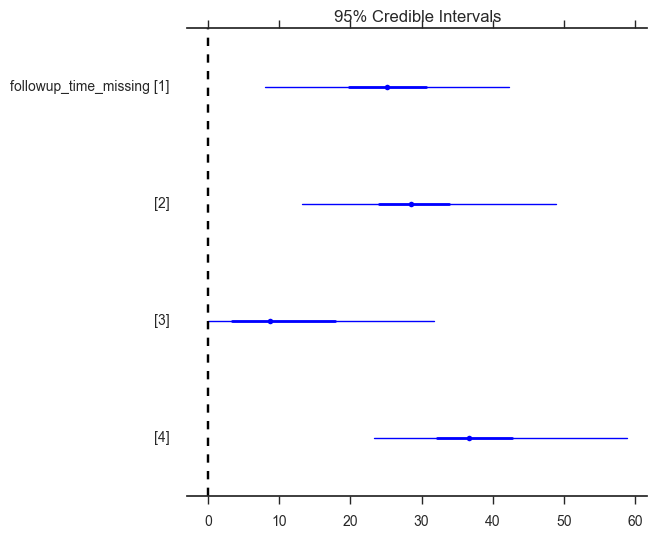

In [82]:
pm.forestplot(trace_uae[n_burn:], varnames=['followup_time_missing'])

Baseline estimates for each outcome, on the log scale.

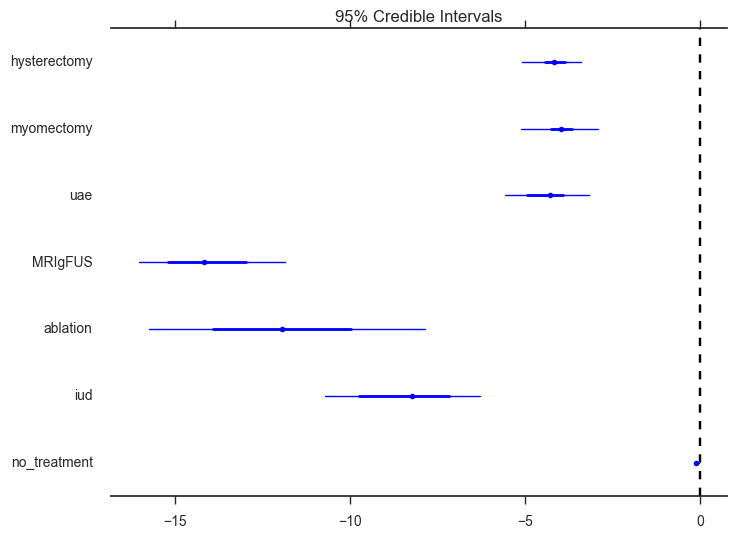

In [83]:
pm.forestplot(trace_uae[n_burn:], varnames=['μ'], ylabels=outcome_cats)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ac76cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1159edac8>]], dtype=object)

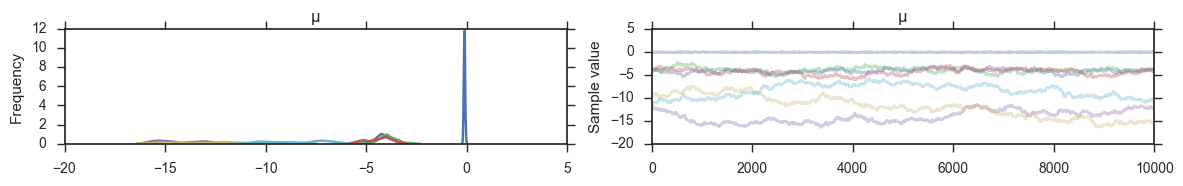

In [84]:
pm.traceplot(trace_uae[n_burn:], varnames=['μ'])

Follow-up time effect size estimates. Positive values indicate higher probability of event with increased follow-up time.

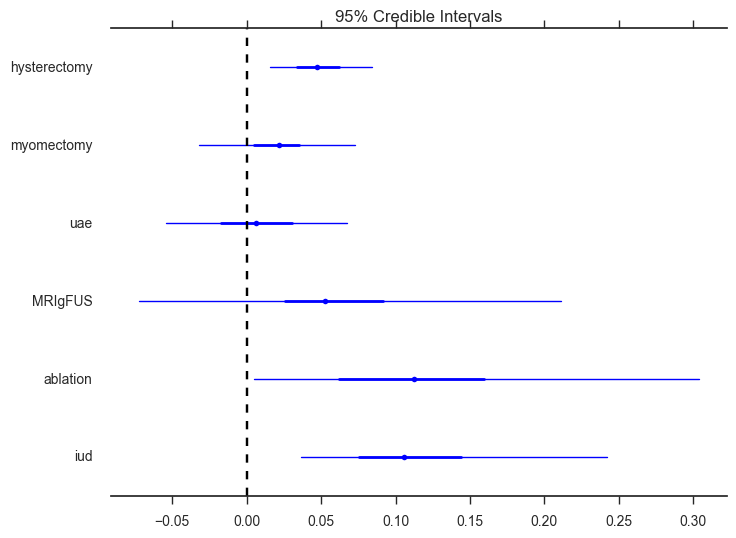

In [85]:
pm.forestplot(trace_uae[n_burn:], varnames=['θ_fup'], ylabels=outcome_cats[:-1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126d71908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x132ac4748>]], dtype=object)

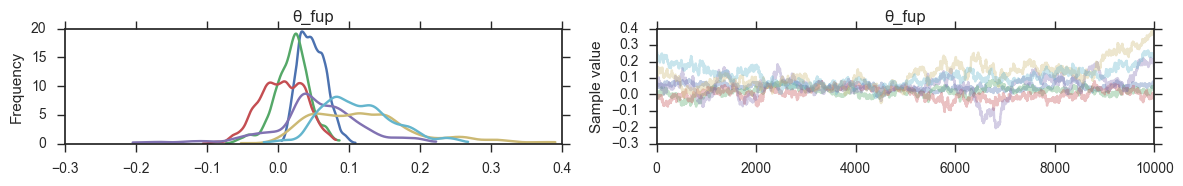

In [86]:
pm.traceplot(trace_uae[n_burn:], varnames=['θ_fup'])

Age effect size estimates. Positive values suggest higher probability of event with each year above age 40.

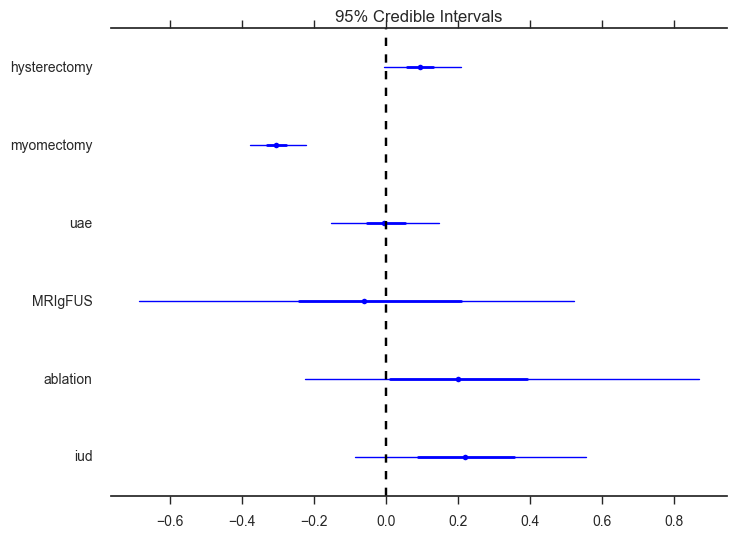

In [87]:
pm.forestplot(trace_uae[n_burn:], varnames=['θ_age'], ylabels=outcome_cats[:-1])

Estimated probabilities of follow-up interventions for 6-month followup and age 40.

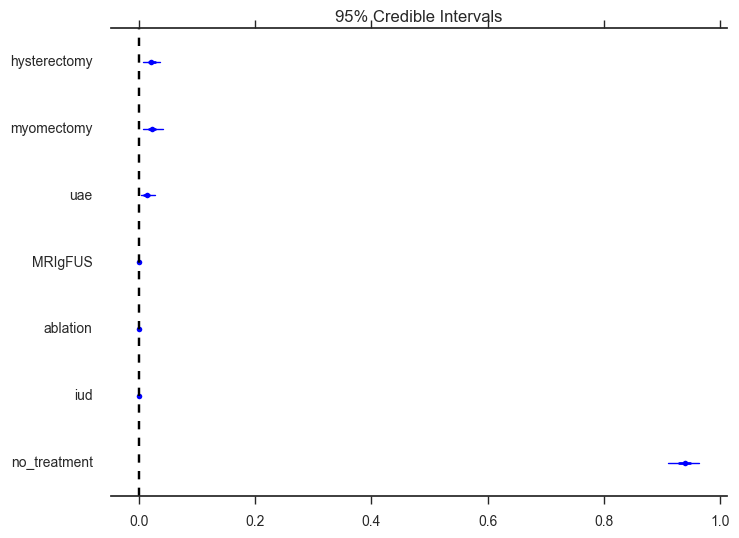

In [88]:
pm.forestplot(trace_uae[n_burn:], varnames=['p_6_40'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 12-month followup and age 40.

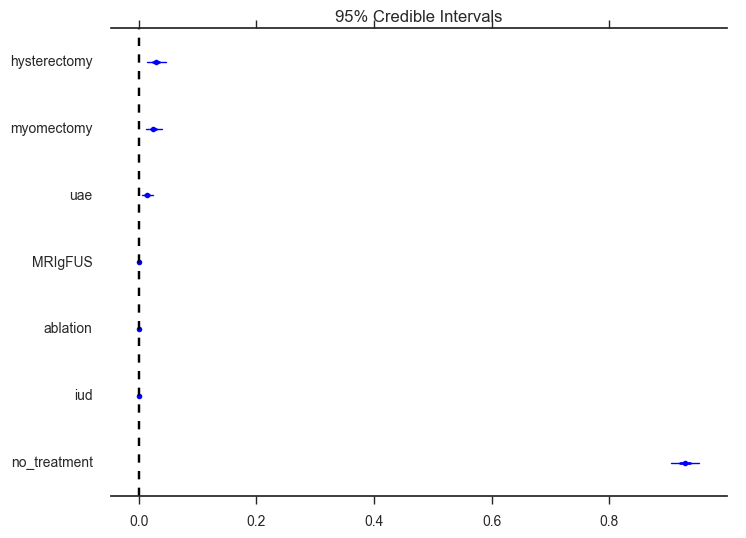

In [89]:
pm.forestplot(trace_uae[n_burn:], varnames=['p_12_40'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 24-month followup and age 40.

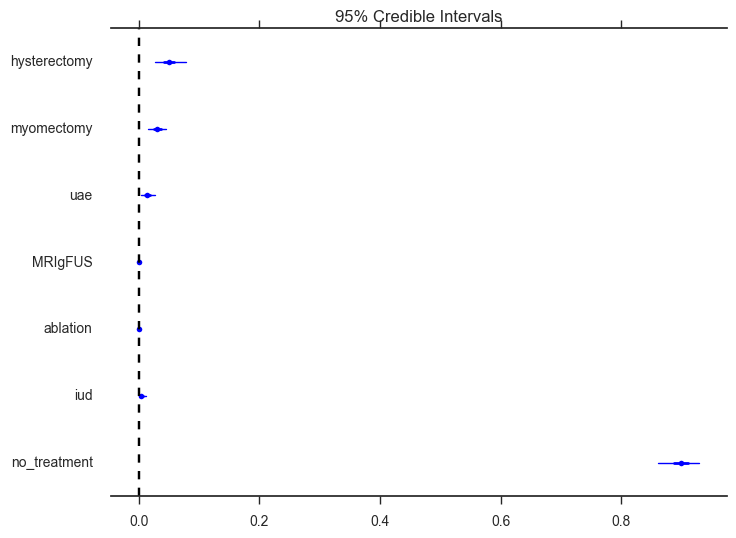

In [90]:
pm.forestplot(trace_uae[n_burn:], varnames=['p_24_40'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 6-month followup and age 30.

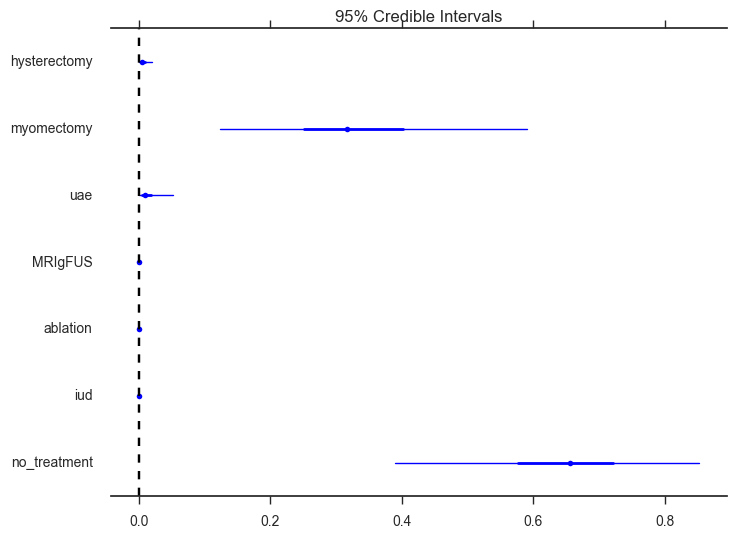

In [91]:
pm.forestplot(trace_uae[n_burn:], varnames=['p_6_30'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 6-month followup and age 50.

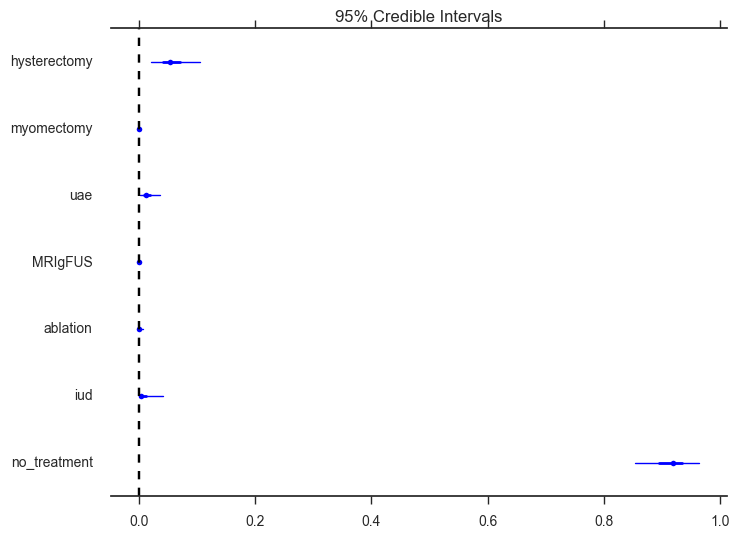

In [92]:
pm.forestplot(trace_uae[n_burn:], varnames=['p_6_50'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 24-month followup and age 30.

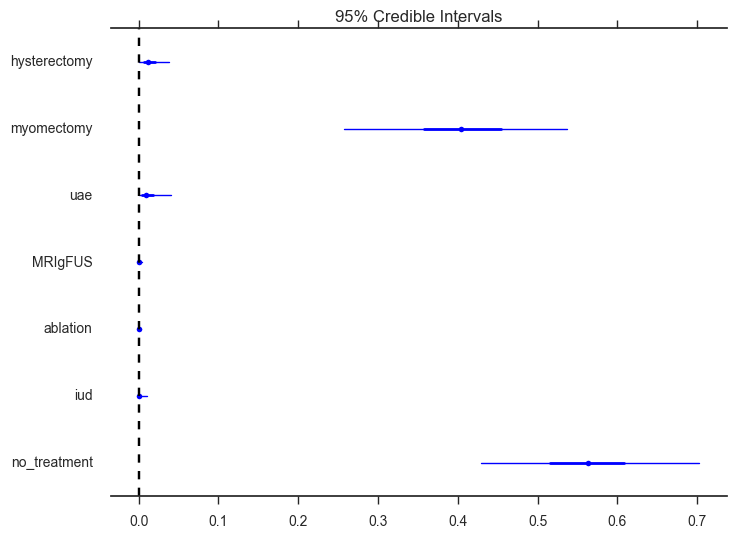

In [93]:
pm.forestplot(trace_uae[n_burn:], varnames=['p_24_30'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 24-month followup and age 50.

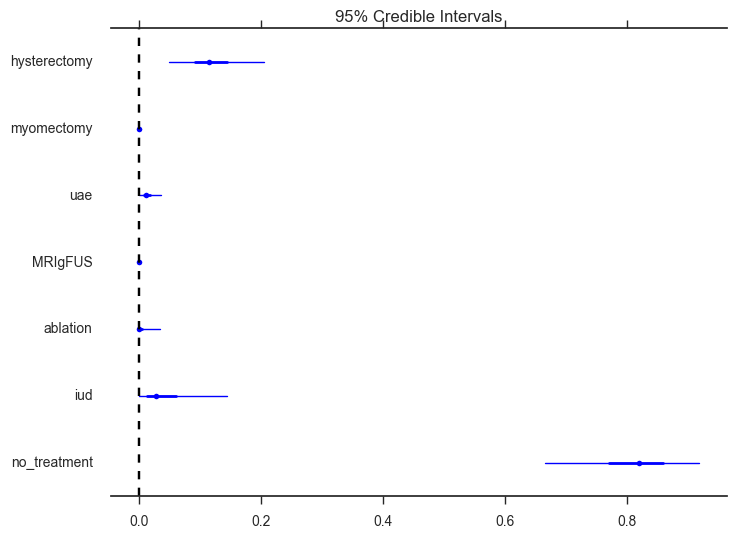

In [94]:
pm.forestplot(trace_uae[n_burn:], varnames=['p_24_50'], ylabels=outcome_cats)

In [95]:
scenarios = ['p_6_40', 'p_12_40', 'p_24_40', 'p_6_50', 'p_12_50', 'p_6_30', 'p_24_50', 'p_24_30', 'p_12_30']

In [96]:
median = lambda x: pd.Series(np.median(x, 0), name='median')

def generate_table(model, trace):
    
    tables = []

    for scenario in scenarios:

        table = pm.df_summary(trace, varnames=[scenario], 
                             stat_funcs=[median], extend=True).round(3).drop(['mc_error', 'mean'], axis=1)
        table.index = outcome_cats[:-1] + ['none']

        tokens = scenario.split('_')
        fup = int(tokens[1])
        age = int(tokens[2])

        table['age'] = age
        table['followup'] = fup
        table.index.name = 'next intervention'

        tables.append(table)
        
    return (pd.concat(tables).set_index(['age', 'followup'], append=True)
                 .reorder_levels([1,2,0])
                 .sort_index(level='age'))[['median', 'sd', 'hpd_2.5', 'hpd_97.5']]


In [97]:
uae_table = generate_table(uae_model, trace_uae[n_burn:])

In [98]:
pd.set_option('notebook_repr_html', False)
pd.set_option('max_rows', 100)

In [99]:
uae_table

                                median     sd  hpd_2.5  hpd_97.5
age followup next intervention                                  
30  6        MRIgFUS             0.000  0.001    0.000     0.001
             ablation            0.000  0.000    0.000     0.000
             hysterectomy        0.006  0.007    0.000     0.020
             iud                 0.000  0.001    0.000     0.001
             myomectomy          0.317  0.120    0.124     0.590
             none                0.656  0.119    0.391     0.852
             uae                 0.009  0.017    0.000     0.052
    12       MRIgFUS             0.000  0.002    0.000     0.001
             ablation            0.000  0.001    0.000     0.001
             hysterectomy        0.007  0.008    0.000     0.024
             iud                 0.000  0.002    0.000     0.003
             myomectomy          0.348  0.098    0.171     0.562
             none                0.627  0.097    0.414     0.799
             uae         

In [100]:
cmap = sns.color_palette(['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#636363','#252525'])

In [101]:
def factorplot(table):
    
    table_flat = table.reset_index().rename(columns = {'median':'probability'})
    
    sns.factorplot(x="followup", y="probability", hue="next intervention", col="age", 
                   data=table_flat[table_flat['next intervention']!='none'], palette=cmap,
                   facet_kws={'ylim':(0,0.6)})

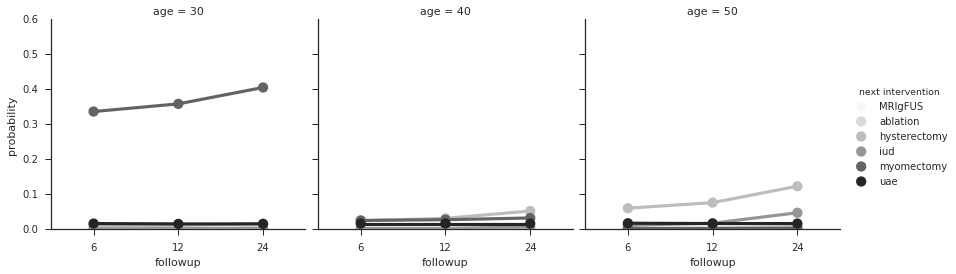

In [72]:
factorplot(uae_table)

In [102]:
def facet_plot(trace, rot=70):
    
    probabilities = pd.concat([pd.DataFrame(trace[s], columns=outcome_cats).assign(followup=s.split('_')[1],
                                        age=s.split('_')[2]) for s in scenarios])
    
    prob_long = (pd.melt(probabilities, 
                   id_vars=['age', 'followup'], 
                    var_name='intervention', value_name='probability')
            .replace({'intervention':{'no_treatment': 'no treatment',
                                     'uae': 'UAE',
                                     'iud': 'IUD'}}))
    
    axes = sns.factorplot(x='intervention', y='probability', row='followup', col="age", data=prob_long, 
               kind="box", size=5, linewidth=0.6, fliersize=0, color=cmap[3])
    axes.set_xticklabels(rotation=rot)
    
    return axes

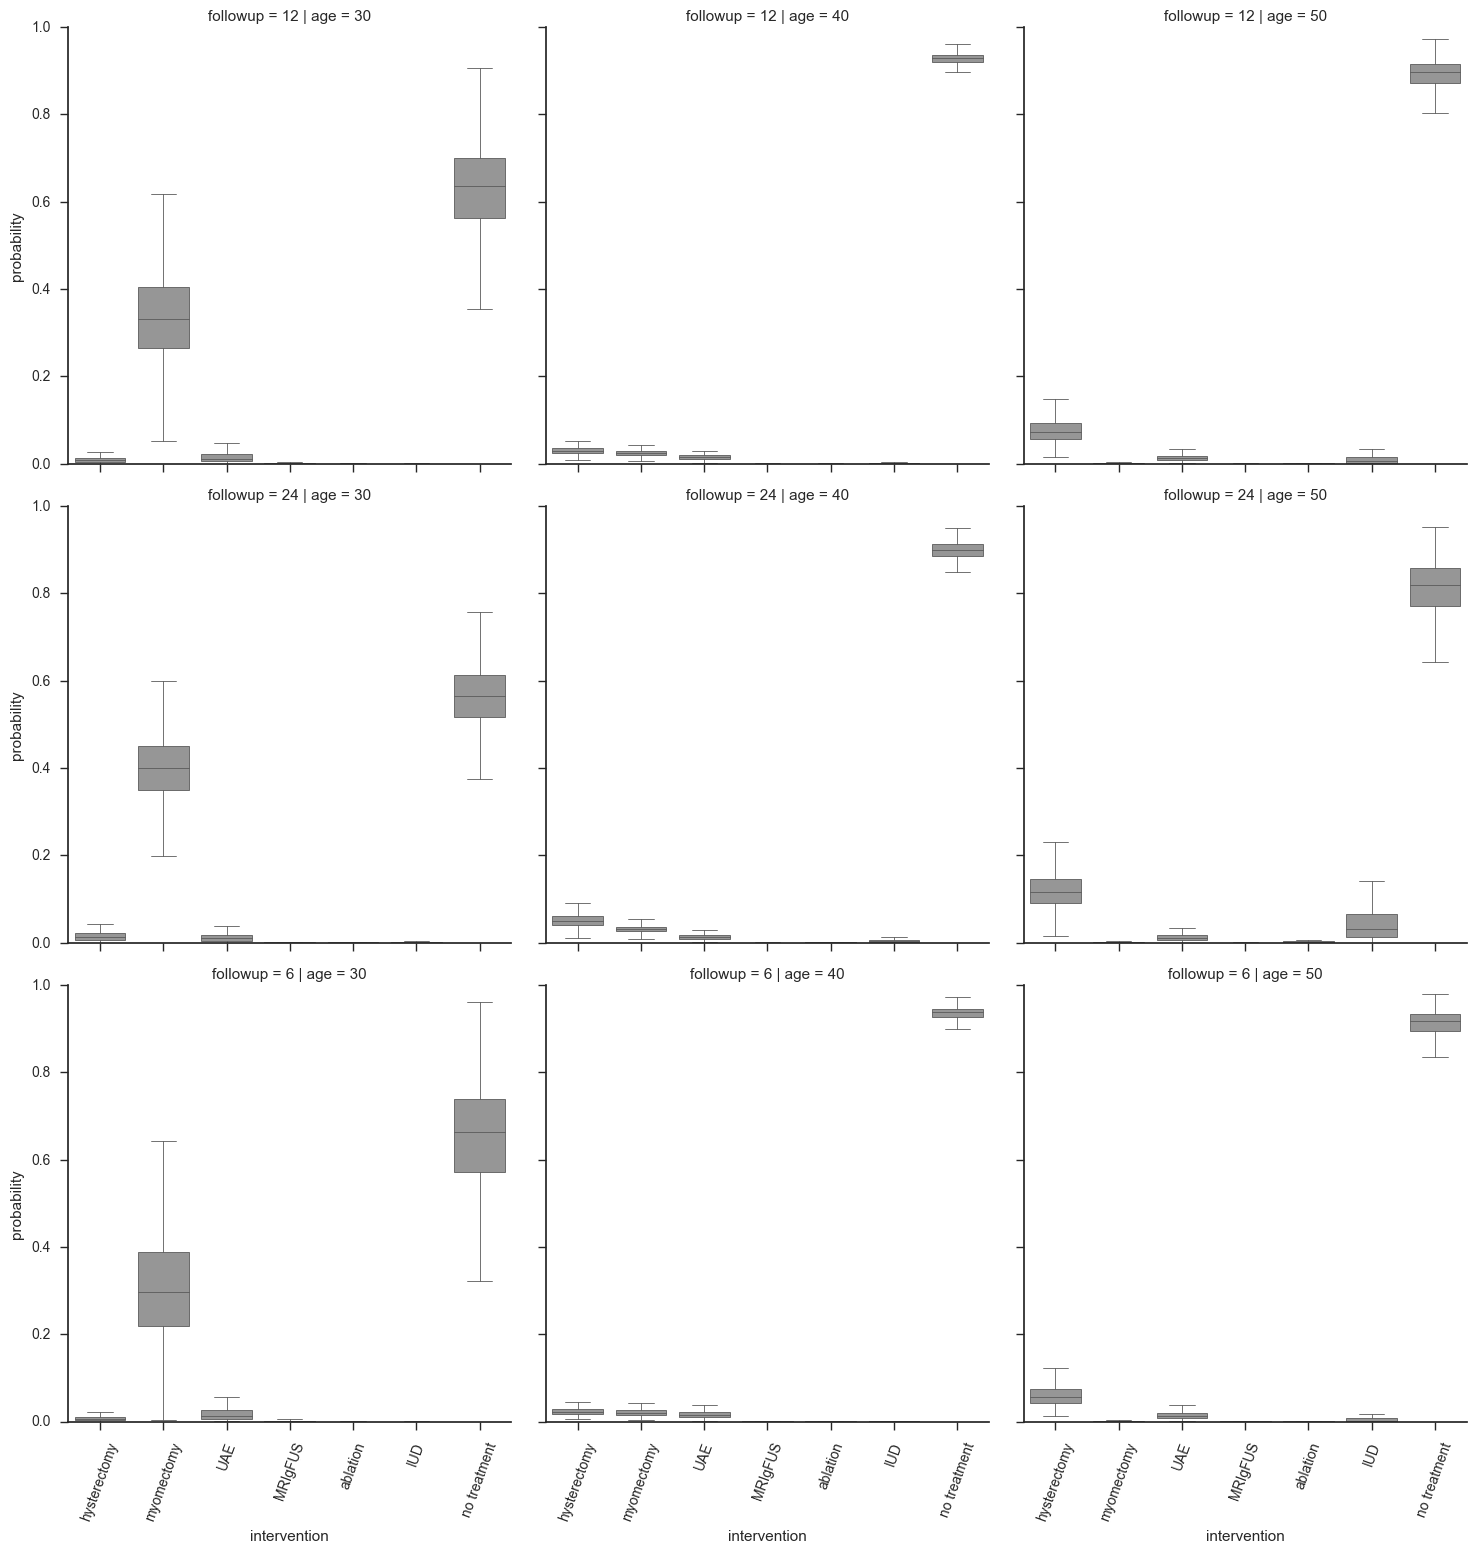

In [103]:
facet_plot(trace_uae)

In [104]:
uae_table_flat = uae_table.reset_index().rename(columns = {'median':'probability'}).drop(['sd'],
                                                                                      axis=1)

### Myomectomy model

In [43]:
dataset[(dataset.intervention_cat=='myomectomy')
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)].study_id.unique()

array([1889, 2375, 3690, 5474,  392, 3263, 3665, 3803, 1546])

In [64]:
myomectomy_model = specify_model(pm.Model(), 'myomectomy')

In [65]:
with myomectomy_model:
    
    trace_myomectomy = pm.sample(n_iterations, step=pm.Metropolis(), 
                          random_seed=20140925)

100%|██████████| 100000/100000 [05:32<00:00, 301.11it/s] | 1/100000 [00:00<5:07:33,  5.42it/s]


Baseline estimates on log scale

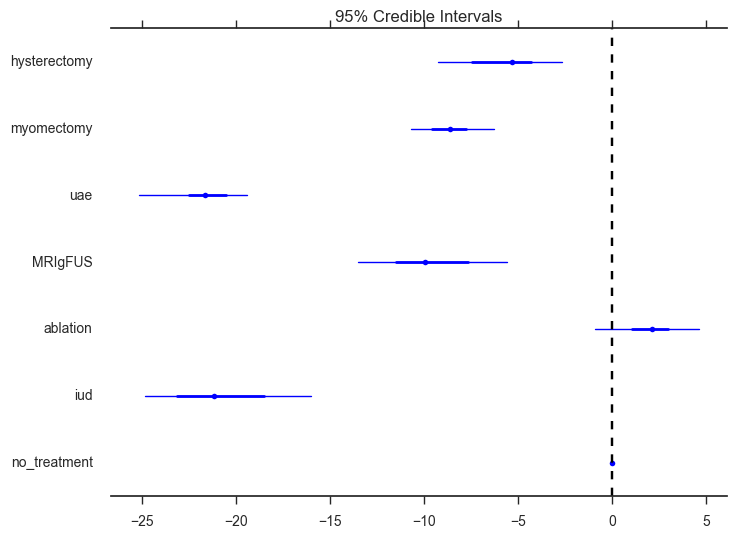

In [66]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['μ'], ylabels=outcome_cats)

Followup time effect

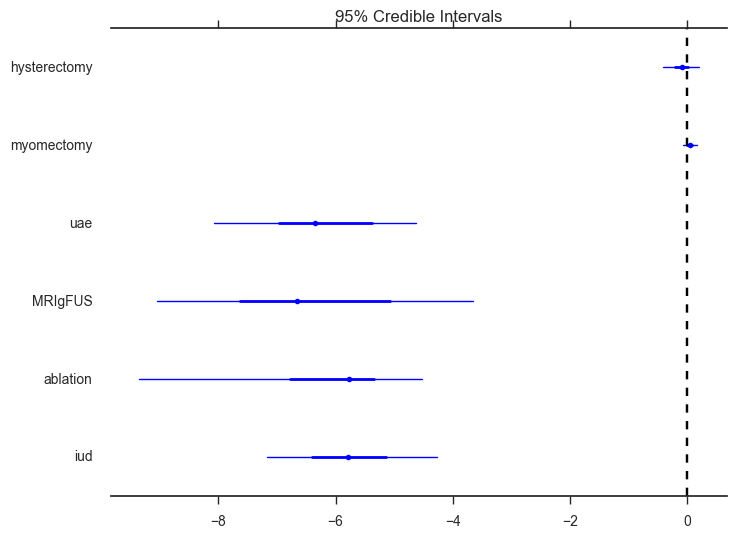

In [67]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['θ_fup'], ylabels=outcome_cats[:-1])

Age over 40 effect

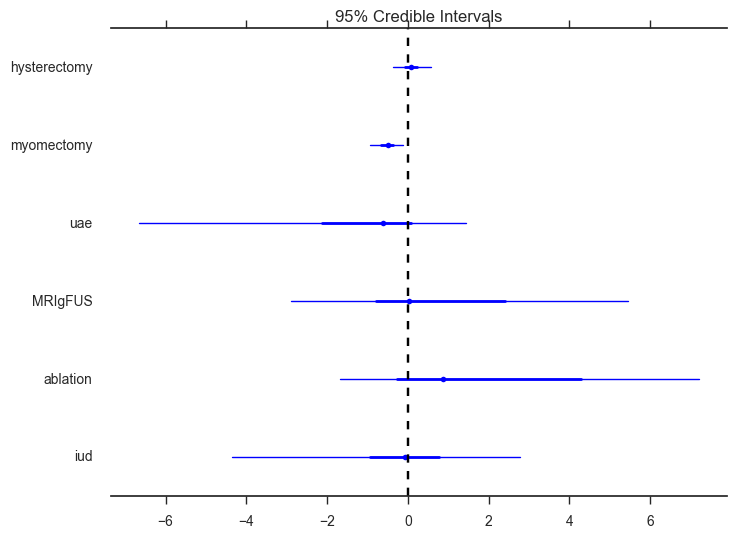

In [68]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['θ_age'], ylabels=outcome_cats[:-1])

Predicted probabilities for 6 months after followup, 40 years of age.

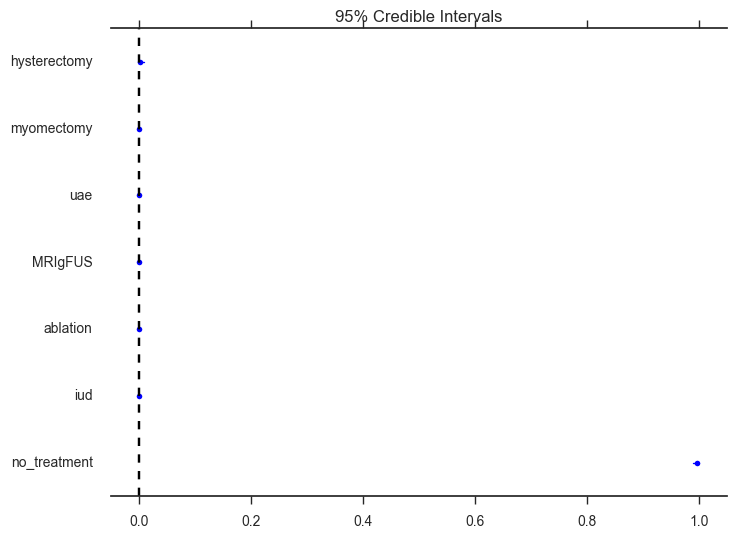

In [69]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['p_6_40'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 12-month followup and age 40.

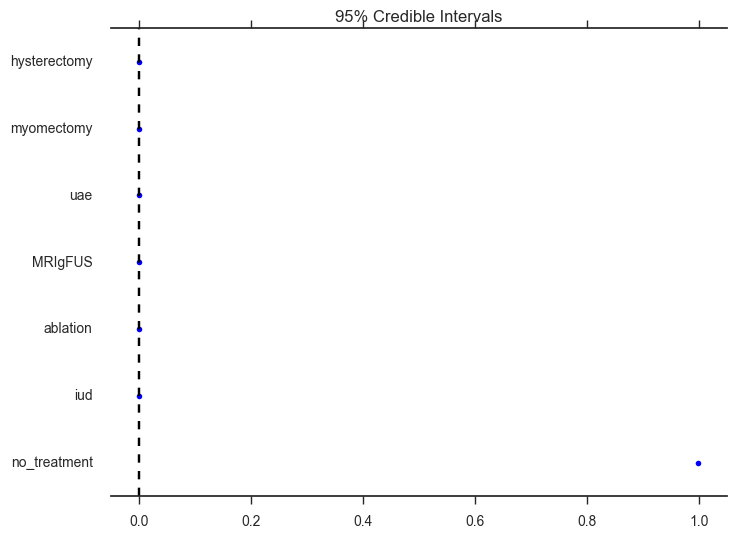

In [70]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['p_12_40'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 24-month followup and age 40.

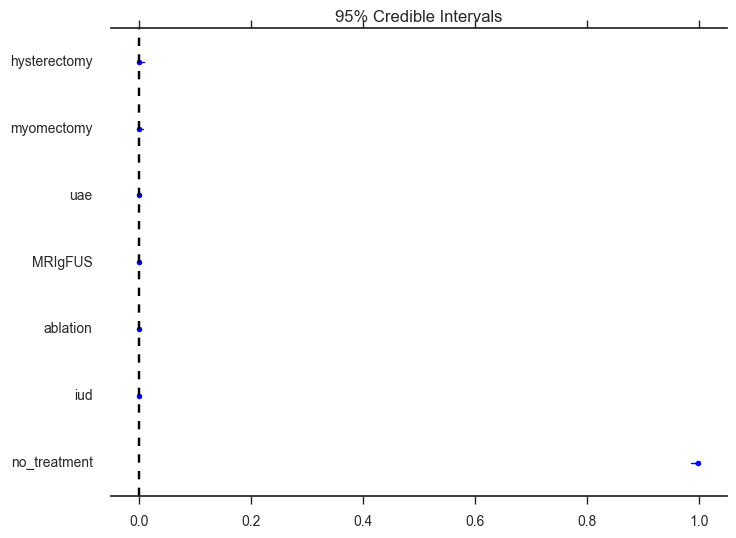

In [71]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['p_24_40'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 6-month followup and age 30.

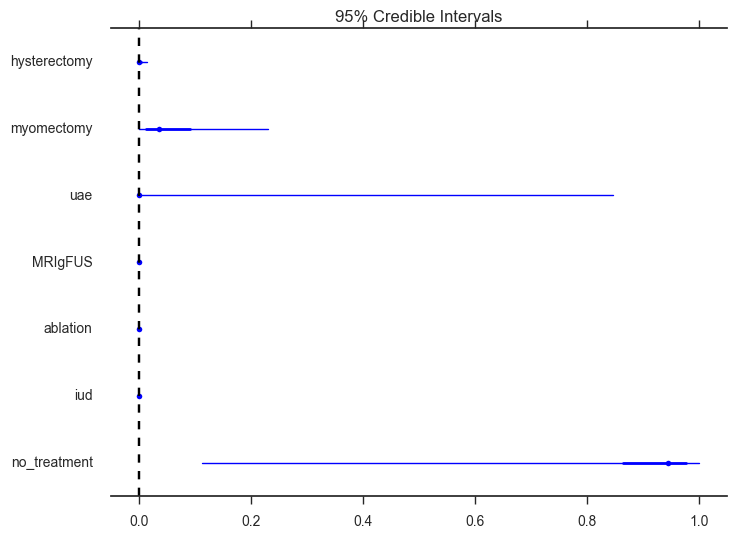

In [72]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['p_6_30'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 6-month followup and age 50.

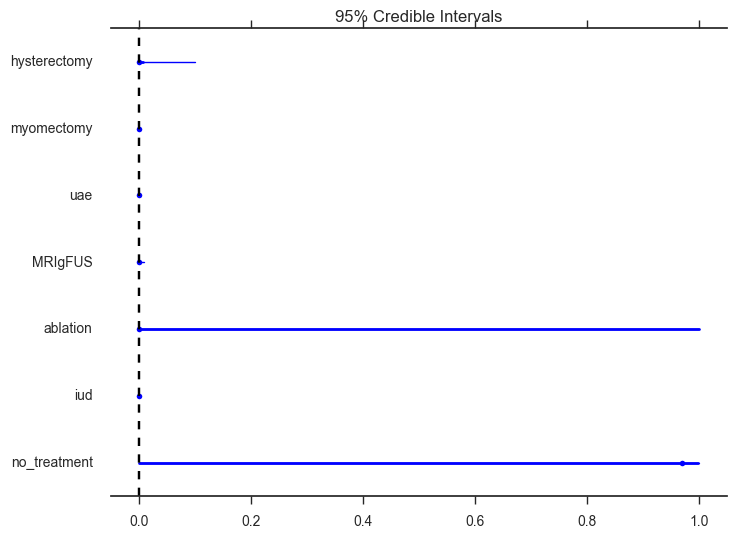

In [73]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['p_6_50'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 24-month followup and age 30.

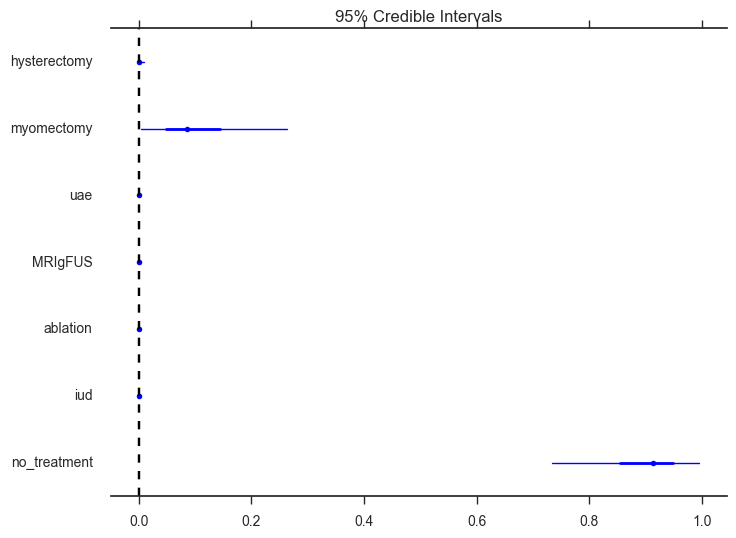

In [74]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['p_24_30'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 24-month followup and age 50.

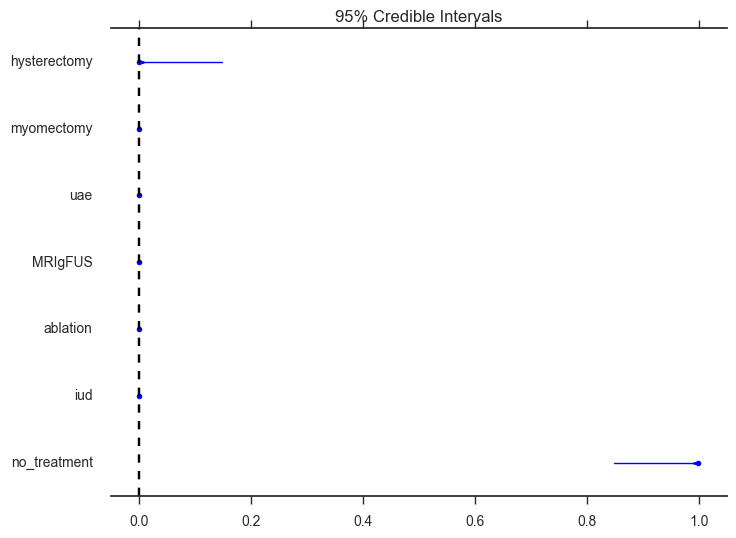

In [75]:
pm.forestplot(trace_myomectomy[n_burn:], varnames=['p_24_50'], ylabels=outcome_cats)

In [76]:
myomectomy_table = generate_table(myomectomy_model, trace_myomectomy[n_burn:])

In [78]:
myomectomy_table_flat = myomectomy_table.reset_index().rename(columns = {'median':'probability'}).drop(['sd'],
                                                                                      axis=1)

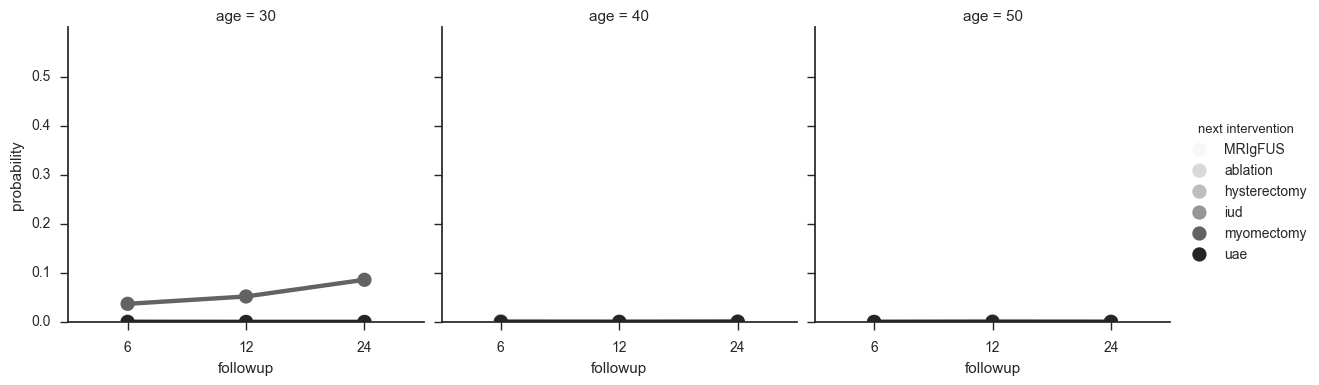

In [105]:
factorplot(myomectomy_table)

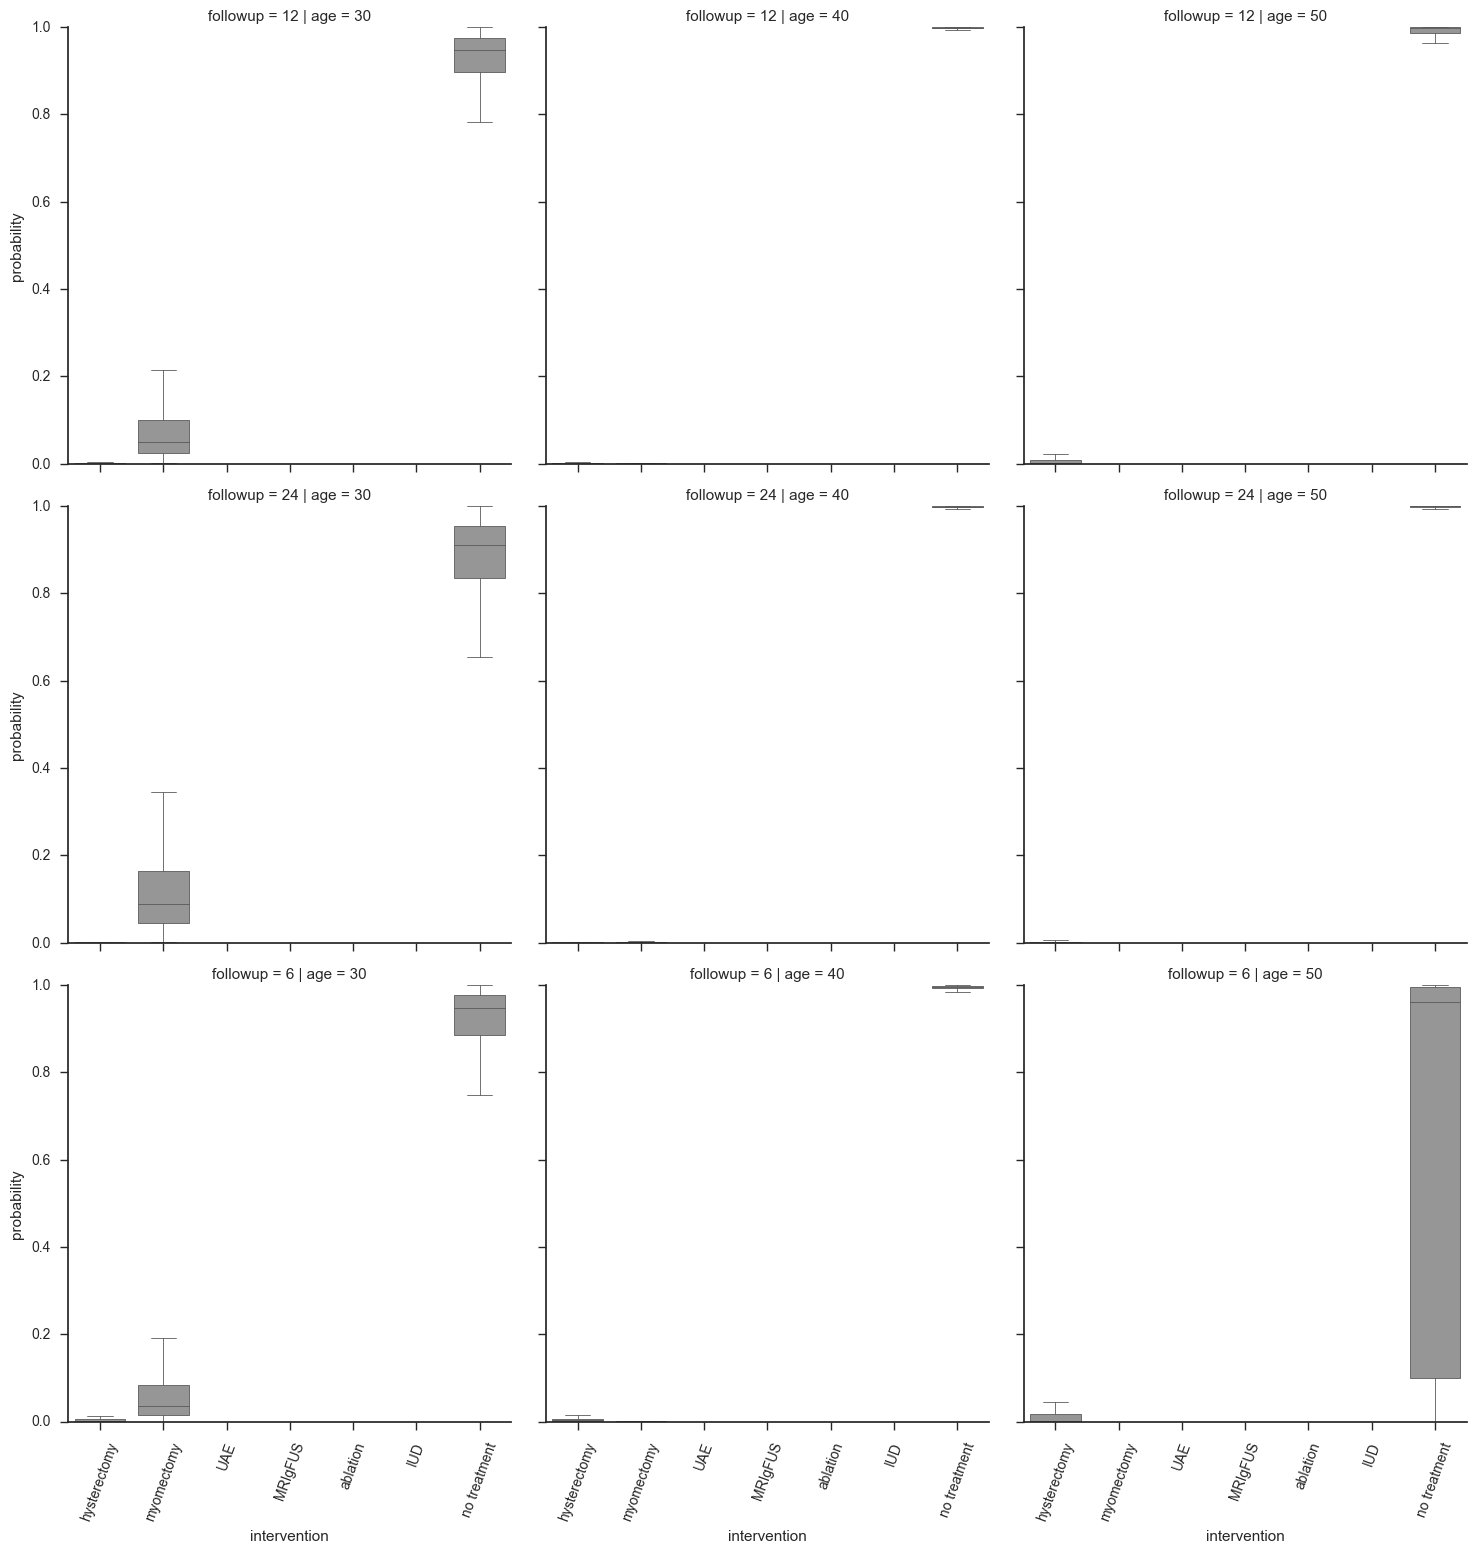

In [106]:
facet_plot(trace_myomectomy)

### Medical management model

In [42]:
dataset[(dataset.intervention_cat=='med_manage')
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)].study_id.unique()

array([1849, 3181, 4468, 4858, 4960, 5276, 5302, 7797, 7936,   95,  629,
        757, 2318, 2555, 3312, 5721, 6393, 7530])

In [107]:
med_manage_model = specify_model(pm.Model(), 'med_manage')

In [108]:
with med_manage_model:
    
    trace_med_manage = pm.sample(n_iterations, step=pm.Metropolis(), 
                          random_seed=20140925)


100%|██████████| 100000/100000 [14:15<00:00, 116.89it/s] | 1/100000 [00:00<5:48:52,  4.78it/s]


Baseline log-probabilities

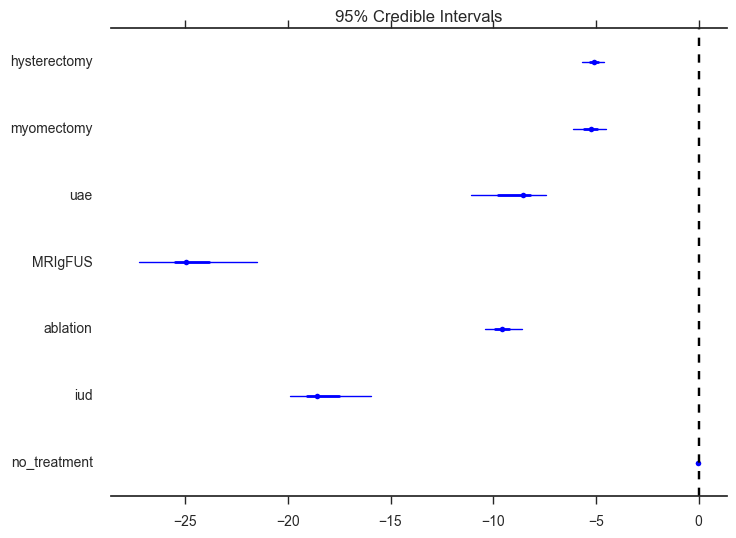

In [109]:
pm.forestplot(trace_med_manage[n_burn:], varnames=['μ'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 6-month followup and age 40.

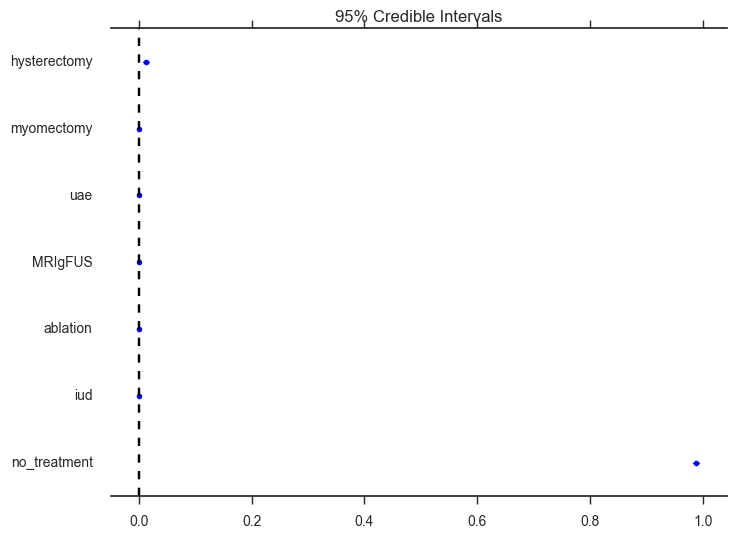

In [110]:
pm.forestplot(trace_med_manage[n_burn:], varnames=['p_6_40'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 12-month followup and age 40.

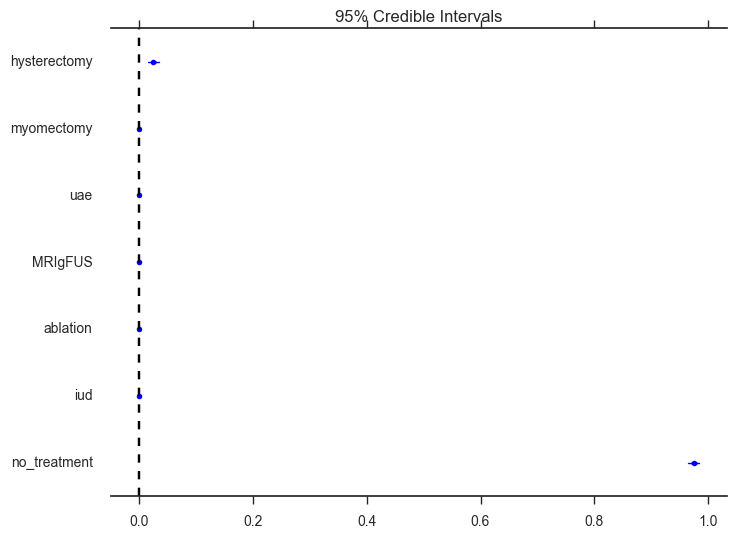

In [111]:
pm.forestplot(trace_med_manage[n_burn:], varnames=['p_12_40'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 24-month followup and age 40.

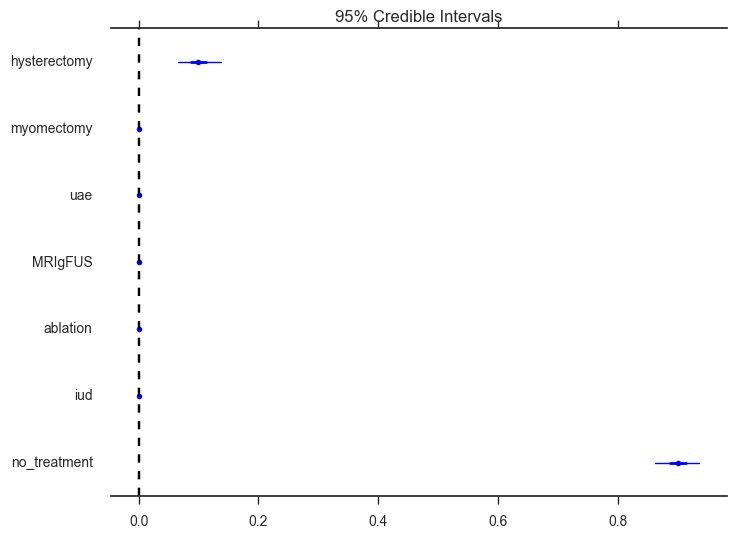

In [112]:
pm.forestplot(trace_med_manage[n_burn:], varnames=['p_24_40'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 6-month followup and age 30.

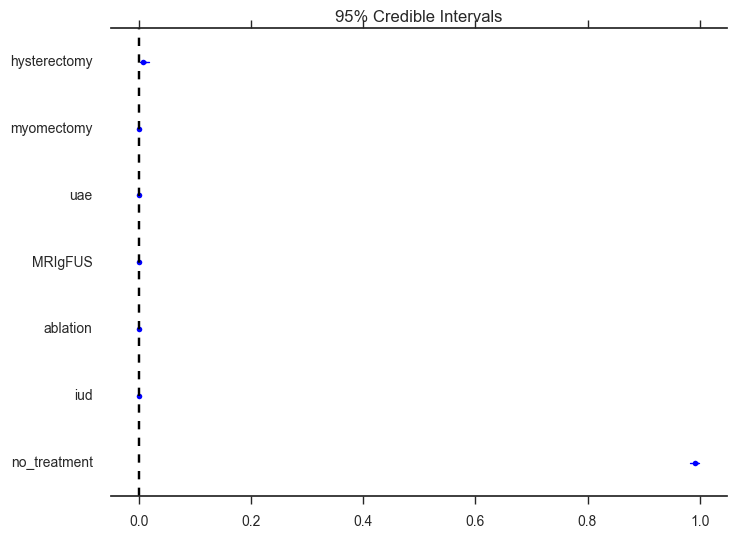

In [113]:
pm.forestplot(trace_med_manage[n_burn:], varnames=['p_6_30'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 6-month followup and age 50.

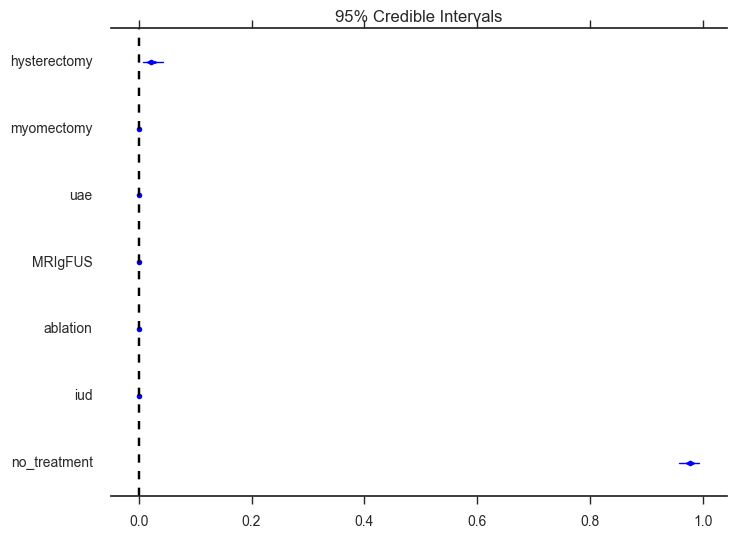

In [114]:
pm.forestplot(trace_med_manage[n_burn:], varnames=['p_6_50'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 24-month followup and age 30.

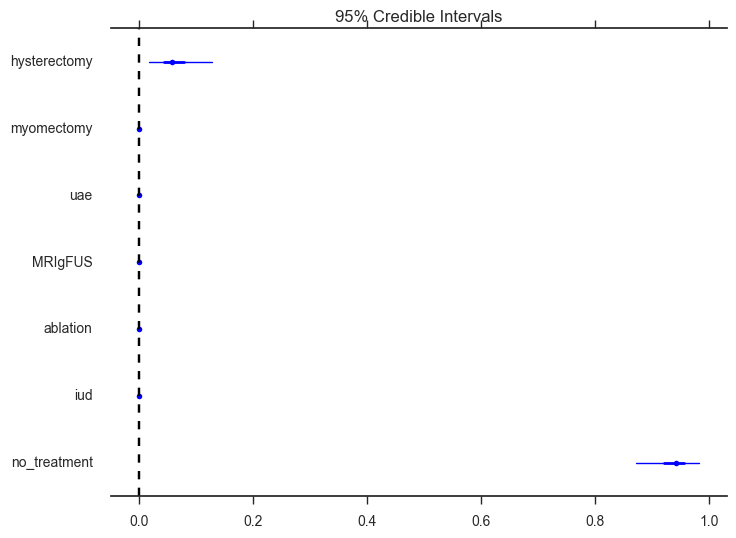

In [115]:
pm.forestplot(trace_med_manage[n_burn:], varnames=['p_24_30'], ylabels=outcome_cats)

Estimated probabilities of follow-up interventions for 24-month followup and age 50.

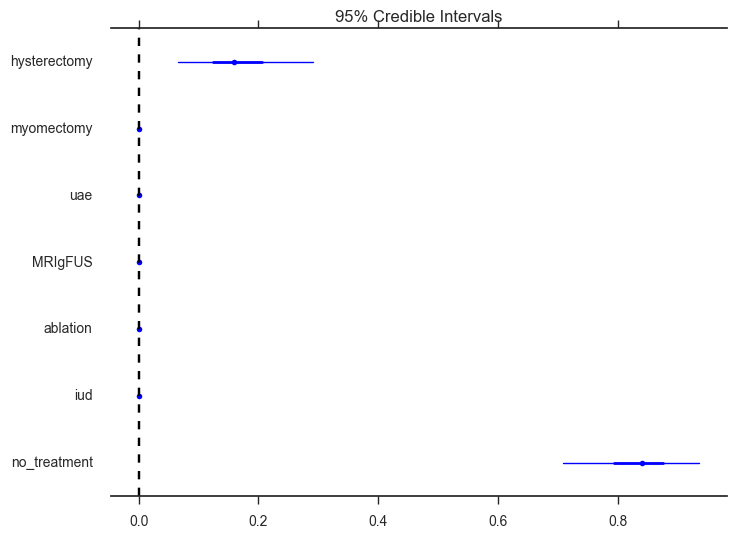

In [116]:
pm.forestplot(trace_med_manage[n_burn:], varnames=['p_24_50'], ylabels=outcome_cats)

In [117]:
med_manage_table = generate_table(med_manage_model, trace_med_manage[n_burn:])

In [118]:
med_manage_table_flat = med_manage_table.reset_index().rename(columns = {'median':'probability'}).drop(['sd'],
                                                                                      axis=1)

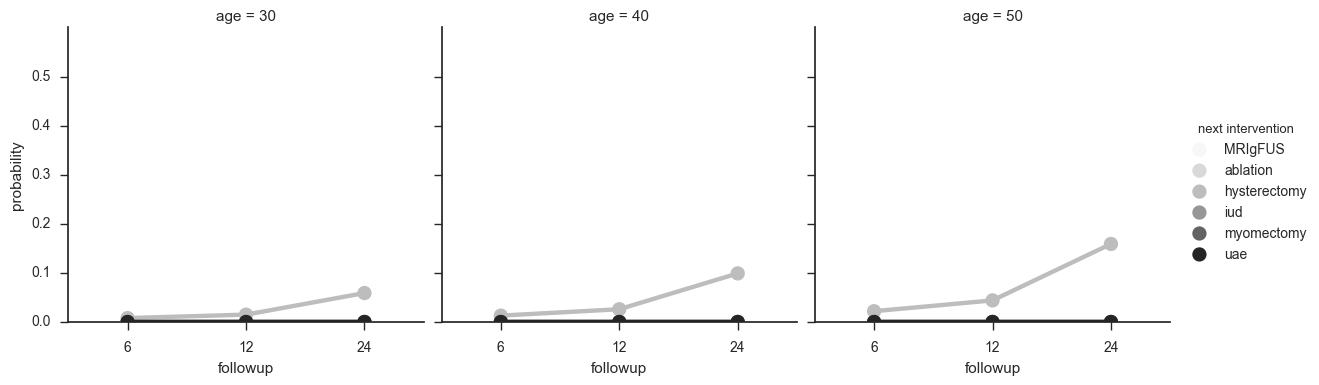

In [119]:
factorplot(med_manage_table)

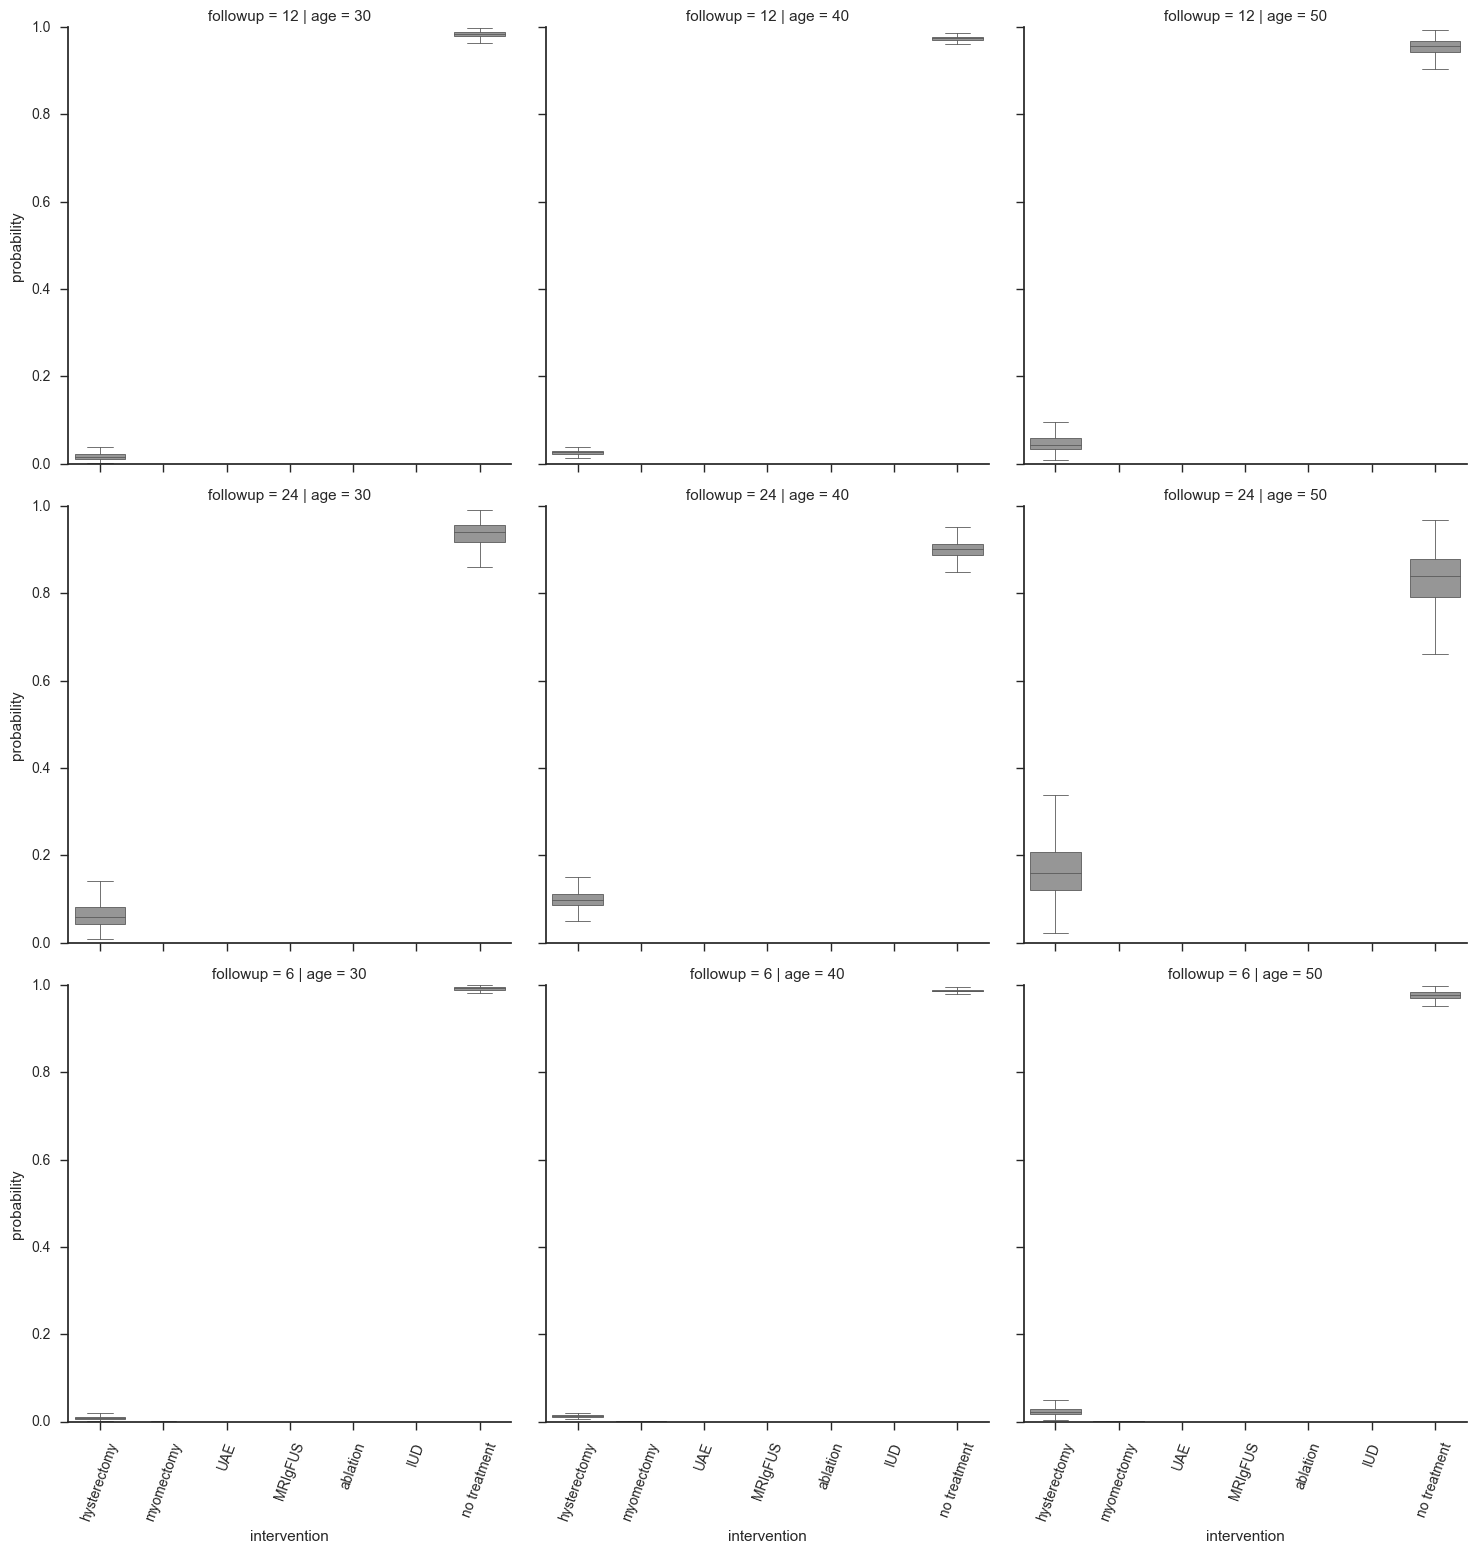

In [120]:
facet_plot(trace_med_manage)

### Summary tables

In [121]:
med_manage_table_flat['initial_treatment'] = 'medical management'
uae_table_flat['initial_treatment'] = 'UAE'
myomectomy_table_flat['initial_treatment'] = 'myomectomy'

In [122]:
all_tables = [med_manage_table_flat, uae_table_flat, myomectomy_table_flat]

In [123]:
full_table = pd.concat(all_tables)

In [124]:
full_table.head()

   age  followup next intervention  probability  hpd_2.5  hpd_97.5  \
0   30         6           MRIgFUS        0.000    0.000     0.000   
1   30         6          ablation        0.000    0.000     0.000   
2   30         6      hysterectomy        0.008    0.002     0.018   
3   30         6               iud        0.000    0.000     0.000   
4   30         6        myomectomy        0.000    0.000     0.000   

    initial_treatment  
0  medical management  
1  medical management  
2  medical management  
3  medical management  
4  medical management  

In [125]:
full_table['probability (95% CI)'] = full_table.apply(lambda x: '{0:1.2f} ({1:1.2f}, {2:1.2f})'.format(x['probability'], 
                                                                                        x['hpd_2.5'], 
                                                                                        x['hpd_97.5']), axis=1)

In [126]:
full_table.head()

   age  followup next intervention  probability  hpd_2.5  hpd_97.5  \
0   30         6           MRIgFUS        0.000    0.000     0.000   
1   30         6          ablation        0.000    0.000     0.000   
2   30         6      hysterectomy        0.008    0.002     0.018   
3   30         6               iud        0.000    0.000     0.000   
4   30         6        myomectomy        0.000    0.000     0.000   

    initial_treatment probability (95% CI)  
0  medical management    0.00 (0.00, 0.00)  
1  medical management    0.00 (0.00, 0.00)  
2  medical management    0.01 (0.00, 0.02)  
3  medical management    0.00 (0.00, 0.00)  
4  medical management    0.00 (0.00, 0.00)  

In [127]:
full_table['next intervention'].value_counts()

hysterectomy    27
myomectomy      27
none            27
ablation        27
uae             27
MRIgFUS         27
iud             27
Name: next intervention, dtype: int64

In [128]:
formatted_tables = {}
for inter,table in full_table.groupby('initial_treatment'):
    table_pivot = table.assign(age_followup=table.age.astype(str)+'-'+table.followup.astype(str)).pivot(index='age_followup', 
                                                            columns='next intervention', 
                                                            values='probability (95% CI)')
    age, followup = np.transpose([(int(a), int(f)) for a,f in table_pivot.index.str.split('-').values])
    table_pivot = table_pivot.set_index([age, followup])
    table_pivot.index.names = 'age', 'followup'
    formatted_tables[inter] = (table_pivot[['none', 'uae', 'iud', 'myomectomy', 'hysterectomy', 'MRIgFUS']]
                               .sortlevel([0,1]))

In [129]:
formatted_tables['UAE']

next intervention               none                uae                iud  \
age followup                                                                 
30  6              0.66 (0.39, 0.85)  0.01 (0.00, 0.05)  0.00 (0.00, 0.00)   
    12             0.63 (0.41, 0.80)  0.01 (0.00, 0.04)  0.00 (0.00, 0.00)   
    24             0.56 (0.43, 0.70)  0.01 (0.00, 0.04)  0.00 (0.00, 0.01)   
40  6              0.94 (0.91, 0.96)  0.01 (0.00, 0.03)  0.00 (0.00, 0.00)   
    12             0.93 (0.91, 0.95)  0.01 (0.01, 0.03)  0.00 (0.00, 0.00)   
    24             0.90 (0.86, 0.93)  0.01 (0.01, 0.03)  0.00 (0.00, 0.01)   
50  6              0.92 (0.85, 0.96)  0.01 (0.00, 0.04)  0.00 (0.00, 0.04)   
    12             0.90 (0.82, 0.95)  0.01 (0.00, 0.04)  0.01 (0.00, 0.06)   
    24             0.82 (0.67, 0.92)  0.01 (0.00, 0.04)  0.03 (0.00, 0.14)   

next intervention         myomectomy       hysterectomy            MRIgFUS  
age followup                                                    

In [130]:
formatted_tables['myomectomy']

next intervention               none                uae                iud  \
age followup                                                                 
30  6              0.94 (0.11, 1.00)  0.00 (0.00, 0.85)  0.00 (0.00, 0.00)   
    12             0.94 (0.77, 1.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    24             0.91 (0.73, 0.99)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
40  6              1.00 (0.99, 1.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    12             1.00 (0.99, 1.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    24             1.00 (0.99, 1.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
50  6              0.97 (0.00, 1.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    12             1.00 (0.08, 1.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    24             1.00 (0.85, 1.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   

next intervention         myomectomy       hysterectomy            MRIgFUS  
age followup                                                    

In [131]:
formatted_tables['medical management']

next intervention               none                uae                iud  \
age followup                                                                 
30  6              0.99 (0.98, 1.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    12             0.98 (0.96, 1.00)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    24             0.94 (0.87, 0.98)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
40  6              0.99 (0.98, 0.99)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    12             0.97 (0.96, 0.98)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    24             0.90 (0.86, 0.94)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
50  6              0.98 (0.96, 0.99)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    12             0.96 (0.92, 0.98)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   
    24             0.84 (0.71, 0.94)  0.00 (0.00, 0.00)  0.00 (0.00, 0.00)   

next intervention         myomectomy       hysterectomy            MRIgFUS  
age followup                                                    

## Model checking

Posterior predictive checks for models. We generate simulated datasets using the model, and check where the observed data lies in the distribution of simulated values. Extreme values of the data percentile is suggestive of problems.

In [132]:
ppc_uae = pm.sample_ppc(trace_uae, model=uae_model, samples=500)

100%|██████████| 500/500 [01:58<00:00,  4.66it/s]     | 1/500 [00:04<38:36,  4.64s/it]


In [133]:
intervention_data = dataset[(dataset.intervention_cat=='uae')
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)].copy()
    
outcomes = intervention_data[[ 'hysterectomy', 'myomectomy', 'uae',
       'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values

In [134]:
from scipy.stats import percentileofscore

Calculate percentiles of each observation relative to simulated data.

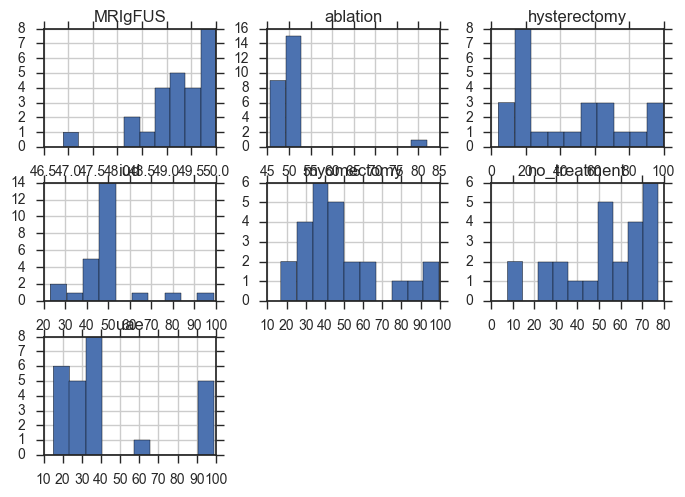

In [135]:
percentiles = []

for label in ppc_uae:
    
    if label.startswith('likelihood'):
        
        tokens = label.split('_')
        index = int(tokens[1])
        
        simvals = ppc_uae[label]
        obsvals = outcomes[index]
        
        p = [percentileofscore(s, o).round(2) for s,o in zip(simvals.T, obsvals)]
        
        percentiles.append(pd.Series(p, index=outcome_cats))
        
pd.concat(percentiles, axis=1).T.hist();